## 1. Data wrangling

## 1.1 Contents<a id='2.1_Contents'></a>
* [1 Data wrangling](#2_Data_wrangling)
  * [1.1 Contents](#2.1_Contents)
  * [1.2 Introduction](#2.2_Introduction)
  * [1.3 Imports](#2.3_Imports)
  * [1.4 Load The House Price Data](#2.4_Load_The_House_Price_Data)
  * [1.5 Filtering Single Family Property Type](#2.5_Filtering_Single_Family_Property_Type) 
  * [1.6 Missing Values](#2.6_Missing_Values) 
    * [1.6.1 Features With > 90% Missing Values](#1.6.1_Features_With_>90%_Missing_Values)
    * [1.6.2 Features With 80%-90% Missing Values](#1.6.2_Features_With_80%_-_90%_Missing_Values)
    * [1.6.3 Features With 70%-80% Missing Values](#1.6.3_Features_With_70%_-_80%_Missing_Values)
    * [1.6.4 Features With 50%-70% Missing Values](#1.6.4_Features_With_50%_-_70%_Missing_Values)
    * [1.6.5 Features With 10%-50% Missing Values](#1.6.5_Features_With_10%_-_50%_Missing_Values)
      * [1.6.5.1 Garage](#1.6.5.1_Garage)
      * [1.6.5.2 Living](#1.6.5.2_Living) 
      * [1.6.5.3 Dining](#1.6.5.3_Dining) 
      * [1.6.5.4 Kitchen](#1.6.5.4_Kitchen)
  * [1.7 Subdivisions And Their Facts](#1.7_Subdivisions_And_their_Facts)
  * [1.8 Fill Null For Kitchen, Dining and Living](#1.8_Fill_Null_For_Kitchen_Dining_Living)
  * [1.9 Listing Price](#1.9_Listing_Price)
  * [1.10 Bedrooms](#1.10_Bedrooms)     
  * [1.11 Bathrooms](#1.11_Bathrooms)
  * [1.12 Stories](#1.12_Stories)
  * [1.13 Style](#1.13_Style)
  * [1.14 Year Built](#1.14_Year_Built)
  * [1.15 Building Sqft](#1.15_Building_Sqft)
  * [1.16 Lot Size](#1.16_Lot_Size)
  * [1.17 Maintenance Fee](#1.17_Maintenance_Fee)
  * [1.18 Fireplace](#1.18_Fireplace)
  * [1.19 HOA Mandatory](#1.19_HOA_Mandatory)
  * [1.20 Other Fees](#1.20_Other_Fees)
  * [1.21 Roof](#1.21_Roof)

## 2.2 Introduction<a id='2.2_Introduction'></a>

In this section I will investigate data scrapped from www.HAR.com. Data cleaning will be done in this stage since all rows are categorical and need to be numerical. I will remove features with lost of none values and will create new features.

## 2.3 Imports<a id='2.3_Imports'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import substring
import os
import re
from fuzzywuzzy import process
import warnings
warnings.filterwarnings('ignore')

## 2.4 Load The House Price Data<a id='2.4_Load_The_House_Price_Data'></a>

In [213]:
data= pd.read_csv('../data/raw/Houston_Home_List.csv',encoding = "ISO-8859-1")
print('data shape is:',data.shape)

data shape is: (15102, 101)


In [214]:
data.columns

Index(['Unnamed: 0', 'image_link', 'Listing Price:', 'Address:', 'City:',
       'State:', 'Zip Code:', 'County:', 'Subdivision:', 'Legal Description:',
       ...
       'Extra Room:', 'Wine Room:', 'Carport Description:',
       'Median Appraised Value / Square ft.:', 'Den:', 'Utility Room Desc:',
       'Sunroom:', 'Guest Suite:', 'Bath:', 'Garage Apartment:'],
      dtype='object', length=101)

## 2.5 Filtering Single Family Property Type<a id='2.5_Filtering_Single_Family_Property_Type'></a>

Since we are going to analysis images and other house features it is important to have all records as same as possible. For example for lots there is no image for building or rooms and features for multi-family properties are different from single family homes. let see what kind of property type we have in our dataset:

In [215]:
data['Property Type:'].value_counts()

Single-Family                          11141
Lots                                    1551
Townhouse/Condo - Townhouse              950
Townhouse/Condo - Condominium            594
Mid/Hi-Rise Condo                        436
Country Homes/Acreage                    154
Multi-Family - Duplex                    107
Country Homes/Acreage - Free Standi       46
Multi-Family - Fourplex                   46
Multi-Family - 5 Plus                     38
Multi-Family - Triplex                    15
Multi-Family - Multiple Detached Dw        9
Country Homes/Acreage - Manufacture        4
Lot & Acreage - Residential                3
Residential - Condo                        2
Single Family                              1
Residential - Townhouse                    1
Name: Property Type:, dtype: int64

Majority of properties are single family so, I keep them and remove the rest of the types.

In [216]:
single_family_df = data[data['Property Type:']=='Single-Family']
single_family_df.reset_index(drop=True,inplace=True)
len(single_family_df)

11141

In [217]:
single_family_df.head()

,Unnamed: 0,image_link,Listing Price:,Address:,City:,State:,Zip Code:,County:,Subdivision:,Legal Description:,...,Extra Room:,Wine Room:,Carport Description:,Median Appraised Value / Square ft.:,Den:,Utility Room Desc:,Sunroom:,Guest Suite:,Bath:,Garage Apartment:
0,85,"['https://photos.harstatic.com/190618667/hr/img-1.jpeg?ts=2020-10-19T10:42:58.003', 'https://pho...","$ 575,000 ($232.98/sqft.) $Convert",1316 Hadley Street,Houston,TX,77002,Harris County,Austin Hadley Place,LT 4 BLK 1 AUSTIN HADLEY PLACE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,88,"['https://photos.harstatic.com/190420550/hr/img-1.jpeg?ts=2020-10-15T13:09:36.753', 'https://pho...","$ 465,000 ($221.85/sqft.) $Convert",110 Pierce Street,Houston,TX,77002,Harris County,Modern Midtown (View subdivision price trend),LT 12 BLK 1 MODERN MIDTOWN,...,NaN,NaN,NaN,$223.83,NaN,NaN,NaN,NaN,NaN,NaN
2,89,"['https://photos.harstatic.com/190088153/hr/img-1.jpeg?ts=2020-10-08T13:52:48.230', 'https://pho...","$ 450,000 ($223.33/sqft.) $Convert",118 Pierce Street,Houston,TX,77002,Harris County,Modern Midtown (View subdivision price trend),LT 8 BLK 1 MODERN MIDTOWN,...,NaN,NaN,NaN,$223.83,NaN,NaN,NaN,NaN,NaN,NaN
3,99,"['https://photos.harstatic.com/189387790/hr/img-1.jpeg?ts=2020-10-22T12:28:16.593', 'https://pho...","$ 259,000 ($203.30/sqft.) $Convert",311 N Milby Street,Houston,TX,77003,Harris County,Merkels Sec 01 (View subdivision price trend),LT 3 BLK 15 MERKELS SEC 1,...,NaN,NaN,NaN,NaN,"['12 x 17, 1st', '12 , 17, 1st']","['12 x 7, 1st', '12 , 7, 1st']",NaN,NaN,NaN,NaN
4,108,"['https://photos.harstatic.com/177650081/hr/img-1.jpeg?ts=2019-08-30T14:53:35.547', 'https://pho...","$ 236,999 ($196.19/sqft.) $Convert \r\n\r\n\r\n Reduced 1.25%\r\n Reduced 1.25%\r\n\r\nReduc...",216 Hutcheson,Houston,TX,77003,Harris County,MERKELS (View subdivision price trend),LT 9 BLK 5 MERKELS SEC 1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In our dataset `State` and `Property Type` are the same for all houses so, we can remove them:

In [218]:
single_family_df.drop(['Unnamed: 0','State:','Property Type:'],axis=1,inplace=True)

## 2.6 Missing Values<a id='2.6_Missing_Values'></a>

In [219]:
# function to find missing value and returning count abd %
def missing_cal(df):
    """This function calculates missing value 
    for datafaram passed in as parameter"""
    missing = pd.concat([single_family_df.isnull().sum(), 100 * single_family_df.isnull().mean()], axis=1)
    missing.columns=['count', '%']
    missing.sort_values(by='count',ascending=False)
    return missing

In [220]:
missing = missing_cal(single_family_df)
missing

,count,%
image_link,0,0.000000
Listing Price:,3,0.026928
Address:,0,0.000000
City:,0,0.000000
Zip Code:,0,0.000000
...,...,...
Utility Room Desc:,7178,64.428687
Sunroom:,10909,97.917602
Guest Suite:,11008,98.806211
Bath:,9449,84.812853


## 1.6.1 Features With >90% Missing Values<a id='1.6.1_Features_With_>90%_Missing_Values'></a>

Let's take a look at features with more than 90% missing values: 

In [221]:
missing = missing_cal(single_family_df)
nan_90 = missing.loc[missing['%']>90].index
print('Number of Features with more than 90% None: ',len(nan_90))

Number of Features with more than 90% None:  9


In [222]:
missing.loc[nan_90].sort_values(by="%")

,count,%
Extra Room:,10068,90.368908
Median Appraised Value / Square ft.:,10217,91.706310
Media Room:,10254,92.038417
Carport Description:,10523,94.452922
Water Amenity:,10747,96.463513
Garage Apartment:,10822,97.136702
Sunroom:,10909,97.917602
Wine Room:,11002,98.752356
Guest Suite:,11008,98.806211


We need to see what kind of information are in each of these features:

In [223]:
for item in nan_90:
    print('Value Count for '+item)
    print(single_family_df[item].value_counts())
    print('-'*100)

Value Count for Media Room:
['2nd', '2nd']                      27
['16x12, 2nd', '4.88 x 3.66(m)']    17
['15x13, 2nd', '4.57 x 3.96(m)']    15
['14x13, 2nd', '4.27 x 3.96(m)']    15
['13x15, 2nd', '3.96 x 4.57(m)']    13
                                    ..
['16X16, 2nd', '4.88 x 4.88(m)']     1
['17X14, 1st', '5.18 x 4.27(m)']     1
['21x10, 2nd', '6.40 x 3.05(m)']     1
['24x14, 2nd', '7.32 x 4.27(m)']     1
['13x14, 2nd', '3.96 x 4.27(m)']     1
Name: Media Room:, Length: 454, dtype: int64
----------------------------------------------------------------------------------------------------
Value Count for Water Amenity:
Lake View                                                     119
Lake View, Lakefront                                           83
Pond                                                           55
Lakefront                                                      48
Bayou Frontage, Bayou View                                      9
Bayou View                          

* Values for `Media Room`, `Extra Room`, `Wine Room`, `Sunroom`, `Guest Suite`and `Garage Apartment` are kind of dimension of each of those rooms along with some nonsense values like (`Yes` for `Garage Apartment`). 
* For `Water Amenity` there are to much unique categories and there is no way to be able to fill rest of none values with correct category
* `Carport Description` has 3 different categories for total 611 house and the rest do not have any carport so I will fill  all none values with new category as 'Not Applicable'.
* `Median Appraised Value / Square ft.:` is the fact (based on active listing) for each subdivision and can be fill by the value for same subdivision.

In [224]:
# Replacing None value for 'Carport Description:' with 'not applicable'
single_family_df['Carport Description:'][single_family_df['Carport Description:'].isnull()]='not applicable'

# Dropping 'Media Room:', 'Water Amenity:', 'Extra Room:', 'Wine Room:', 
#'Sunroom:', 'Guest Suite:', 'Garage Apartment:', 'Vacation Rental:'
single_family_df.drop(['Media Room:', 'Water Amenity:', 'Extra Room:', 'Wine Room:', 'Sunroom:', 'Guest Suite:', 
                       'Garage Apartment:'],axis=1,inplace=True)

## 1.6.2 Features With 80%-90% Missing Values<a id='1.6.2_Features_With_80%_-_90%_Missing_Values'></a>

Next step is looking at the features with more than 80% none values:

In [225]:
missing = missing_cal(single_family_df)
nan_80 = missing.loc[missing['%']>80].index
print('Number of Features with more than 80% None: ',len(nan_80))

Number of Features with more than 80% None:  14


In [226]:
missing.loc[nan_80].sort_values(by="%")

,count,%
Average Square Ft.:,9412,84.480747
Average Price/Square Ft.:,9412,84.480747
Market Area Name:,9413,84.489723
Home For Sales:,9413,84.489723
Average List Price:,9413,84.489723
Home For Lease:,9413,84.489723
Average Lease:,9413,84.489723
Average Lease/Square Ft.:,9413,84.489723
Bath:,9449,84.812853
Den:,9486,85.144960


In [227]:
#printing value count for each feature with more than 80 none value
for item in nan_80:
    print('Value Count for '+item)
    print(single_family_df[item].value_counts())
    print('-'*100)

Value Count for Private Pool Desc:
In Ground                                355
Gunite, In Ground                        344
Gunite, Heated, In Ground                234
Gunite                                   217
Heated, In Ground                         92
Gunite, Heated, In Ground, Salt Water     46
Gunite, Heated                            40
Above Ground                              28
Heated, In Ground, Salt Water             21
Gunite, In Ground, Salt Water             20
In Ground, Salt Water                     16
Gunite, Salt Water                        13
Gunite, Heated, Salt Water                10
Enclosed, Heated, In Ground                8
Heated                                     5
In Ground, Vinyl Lined                     5
Fiberglass, In Ground                      5
Salt Water                                 4
Fiberglass                                 4
Enclosed, In Ground                        4
Enclosed, Gunite, In Ground                2
Heated, Salt Water  

* `Controlled Access`categories are mixed  of 'Automatic', 'Driveway', 'Manned' and 'Intercom' that makes me believe the rest of the house do not have any type of controlled access. I think filling none values with 'No controlled access' would be reasonable.
* Same as `Water Amenity` there are so many categories for 'Private Pool Desc'. After counting each category for `Private Pool:` groups figured out that there are description for house without private pool and I think it may happened by mistake and I decided to drop this column.
* `Master Planned Community` and `Market Area Name` categories seems to be same as subdivision name and we will deal with them later on subdivision section
* `Home For Sales`, `Average List Price`,`Average Square Ft.`,`Average Price/Square Ft.`, `Home For Lease`, `Average Lease`and `Average Lease/Square Ft.`, are the facts (based on active listing) for each subdivision and can be fill by the value for same subdivision.
* `Den` and `Bath` are dimension along with other values like '1th' which I think is typo mistake and I decided to drop them.

In [228]:
#counting 'Private Pool Desc:' category for `Private Pool:` groups
single_family_df.groupby('Private Pool:')['Private Pool Desc:'].value_counts()

Private Pool:  Private Pool Desc:                   
No             In Ground                                 14
               Enclosed, Heated, In Ground                6
               Above Ground                               4
               Heated, In Ground                          4
               Gunite                                     3
               Gunite, In Ground                          3
               Fiberglass                                 2
               Gunite, Heated, In Ground                  1
Yes            Gunite, In Ground                        341
               In Ground                                341
               Gunite, Heated, In Ground                233
               Gunite                                   214
               Heated, In Ground                         88
               Gunite, Heated, In Ground, Salt Water     46
               Gunite, Heated                            40
               Above Ground                    

In [229]:
single_family_df.drop(['Private Pool Desc:','Bath:','Den:'],axis=1,inplace=True)
# Replacing None value for 'Carport Description:' with 'not applicable'
single_family_df['Controlled Access:'][single_family_df['Controlled Access:'].isnull()]='no controlled access'

## 1.6.3 Features With 70%-80% Missing Values<a id='1.6.3_Features_With_70%_-_80%_Missing_Values'></a>

Now I investigating features with more than 70% none values:

In [230]:
missing = missing_cal(single_family_df)
nan_70 = missing.loc[((missing['%']>70 )& (missing['%']<80))].index
print('Number of Features with more than 70% None: ',len(nan_70))

Number of Features with more than 70% None:  2


In [231]:
missing.loc[nan_70].sort_values(by="%")

,count,%
Family Room:,7858,70.532268
Primary Bath:,8315,74.634234


In [232]:
#printing value count for each feature with more than 70 none value
for item in nan_70:
    print('Value Count for '+item)
    print(single_family_df[item].value_counts())
    print('-'*100)

Value Count for Family Room:
['1st', '1st']                          75
['18x16, 1st', '5.49 x 4.88(m)']        52
['20x16, 1st', '6.10 x 4.88(m)']        51
['21x17, 1st', '6.40 x 5.18(m)']        39
['18x15, 1st', '5.49 x 4.57(m)']        37
                                        ..
["32' x 15', 1st", "32' , 15', 1st"]     1
['15 x 21.9, 1st', '15 , 21.9, 1st']     1
['15 X 13, 1st', '15 , 13, 1st']         1
['20x26, 1st', '6.10 x 7.92(m)']         1
['16 x 12, 1st', '16 , 12, 1st']         1
Name: Family Room:, Length: 939, dtype: int64
----------------------------------------------------------------------------------------------------
Value Count for Primary Bath:
['1st', '1st']                      765
['2nd', '2nd']                      308
['3rd', '3rd']                      128
['12x10, 1st', '3.66 x 3.05(m)']     31
['12x7, 1st', '3.66 x 2.13(m)']      20
                                   ... 
['18 x 13, 2nd', '18 , 13, 2nd']      1
['18X7, 1st', '5.49 x 2.13(m)']       1
[

`Family Room` and `Primary Bath` are dimension for family room and master bath room and all houses should have these values and can not be 0. I think dropping these features would be appropriate since I can not fill values for more than 70% of houses.

In [233]:
single_family_df.drop(['Family Room:','Primary Bath:'],axis=1,inplace=True)

## 1.6.4 Features With 50%-70% Missing Values<a id='1.6.4_Features_With_50%_-_70%_Missing_Values'></a>

Next step is to look at features with none values between 50% and 70%:

In [234]:
missing = missing_cal(single_family_df)
nan_50_70 = missing.loc[((missing['%']>50 )& (missing['%']<70))].index
print('Number of Features with more than 50% and less than 70% None: ',len(nan_50_70))

Number of Features with more than 50% and less than 70% None:  6


In [235]:
missing.loc[nan_50_70].sort_values(by="%")

,count,%
Front Door:,6471,58.082757
Breakfast:,6724,60.353649
Garage Carport:,6734,60.443407
Utility Room Desc:,7178,64.428687
Game Room:,7367,66.125123
Study/Library:,7658,68.737097


In [236]:
#printing value count for each feature with more than 50 none value
for item in nan_50_70:
    print('Value Count for '+item)
    print(single_family_df[item].value_counts())
    print('-'*100)

Value Count for Breakfast:
['1st', '1st']                                                    192
['10x10, 1st', '3.05 x 3.05(m)']                                  155
['11x10, 1st', '3.35 x 3.05(m)']                                  149
['12x10, 1st', '3.66 x 3.05(m)']                                  147
['10x9, 1st', '3.05 x 2.74(m)']                                   108
                                                                 ... 
['10x6, 1st', '10x6, 1st', '3.05 x 1.83(m)', '3.05 x 1.83(m)']      1
['15x8, 2nd', '4.57 x 2.44(m)']                                     1
['10x9.8, 1st', '3.05 x 2.99(m)']                                   1
['10x07, 1st', '3.05 x 2.13(m)']                                    1
['13x9, 2nd', '3.96 x 2.74(m)']                                     1
Name: Breakfast:, Length: 769, dtype: int64
----------------------------------------------------------------------------------------------------
Value Count for Game Room:
['2nd', '2nd']                 

We can calculate area for `Utility Room`, `Study/Library`. `Game Room`and `Breakfast` based on  dimension we have and assume the NA values are zero for those houses that do not have these rooms. I drop `Garage Carport` and `Front Door` since there is no information for rest of the house.

In [237]:
def area_calc(item,pattern = "([\d.]+)(?:.*?([\d]+))?.*?[x\*].*?([\d]+)(?:.*?([\d.]+))?"):
    """This function calculates are based on dimension passed in as parameter. Regular experession
    pattern will find dimension and group them as feet and inch"""
    pattern = re.compile(pattern,re.IGNORECASE)
    area=0
    dim=[]
    if type(item)==list:
        for i in item:
            if (('x' in i or 'X' in i or '*' in i )and '(m)' not in i ):
                dim.append(i.replace('[','').strip())
        for d in dim:
            d=d.replace(' ','').strip()
            match=pattern.findall(d)
            try:
                dimension_list = [float(item) if len(item)>0 else 0 for item in match[0]]
                area += (dimension_list[0]+(dimension_list[1]/12))*(dimension_list[2]+(dimension_list[3]/12))
            except:
                area=None
        return(area)

In [238]:
# Calculating area for Utility room
single_family_df['UtilitySqft'] = single_family_df['Utility Room Desc:'].str.split(',')
single_family_df['UtilitySqft'] = single_family_df['UtilitySqft'].apply(area_calc)

# Calculating area for Study/Library room
single_family_df['StudySqft'] = single_family_df['Study/Library:'].str.split(',')
single_family_df['StudySqft'] = single_family_df['StudySqft'].apply(area_calc)

# Calculating area for Game room
single_family_df['GameSqft'] = single_family_df['Game Room:'].str.split(',')
single_family_df['GameSqft'] = single_family_df['GameSqft'].apply(area_calc)

# Calculating area for Breakfast
single_family_df['BreakfastSqft'] = single_family_df['Breakfast:'].str.split(',')
single_family_df['BreakfastSqft'] = single_family_df['BreakfastSqft'].apply(area_calc)

single_family_df.update(single_family_df[['UtilitySqft','StudySqft','GameSqft','BreakfastSqft']].fillna(0))

In [239]:
single_family_df.drop(list(nan_50_70),axis=1,inplace=True)

So far I investigated features with the none value more than 50% and still need to dig more and also fill values for features that are the facts (based on active listing) for each subdivision like: `Home For Sales`, `Average List Price`,`Average Square Ft.`,`Average Price/Square Ft.`, `Home For Lease`, `Average Lease`and `Average Lease/Square Ft.`. But before that lets take a look at features with none values more than 10%:

## 1.6.5 Features With 10%-50% Missing Values<a id='1.6.5_Features_With_10%_-_50%_Missing_Values'></a>

In [240]:
missing = missing_cal(single_family_df)
nan_10_50 = missing.loc[((missing['%']>10 )& (missing['%']<50))].index
print('Number of Features with more than 10% and less than 50% None: ',len(nan_10_50))

Number of Features with more than 10% and less than 50% None:  35


In [241]:
missing.loc[nan_10_50].sort_values(by="%")

,count,%
Garage(s):,1292,11.596805
Tax Rate:,1323,11.875056
Dishwasher:,1413,12.682883
Bedroom Desc:,1682,15.097388
Median Appraised Value:,1746,15.671843
Median Year Built:,1746,15.671843
Median Lot Square Ft.:,1746,15.671843
Median Square Ft.:,1746,15.671843
Single Family Properties:,1746,15.671843
County / Zip Code:,1746,15.671843


In [242]:
#printing value count for each feature with more than 50 none value
for item in nan_10_50:
    print('Value Count for '+item)
    print(single_family_df[item].value_counts())
    print('-'*100)

Value Count for Garage(s):
2 / Attached                                    5626
2 / Detached                                    1063
3 / Attached                                     686
1 / Detached                                     341
1 / Attached                                     320
                                                ... 
6 / Attached,Attached/Detached,Detached,Over       1
6 / Attached/Detached,Oversized                    1
5 / Attached,Detached,Oversized                    1
6 / Detached,Oversized                             1
7 / Attached,Oversized                             1
Name: Garage(s):, Length: 114, dtype: int64
----------------------------------------------------------------------------------------------------
Value Count for Living:
['15x13, 1st', '4.57 x 3.96(m)']            58
['14x12, 1st', '4.27 x 3.66(m)']            57
['20x15, 1st', '6.10 x 4.57(m)']            57
['18x15, 1st', '5.49 x 4.57(m)']            55
['20x16, 1st', '6.10 x 4.88(m)'] 

`Room Description`, `Countertop`, `Floors`, `Bedroom Desc`, `Kitchen Desc`, `Bathroom Description`, `Connections`, `Oven`, `Range`, `Energy Feature`, `Interior`, `Exterior`, `Financing Considered` are just information and we can not fill them with unknown values since some may not be accurate and I don't think they are relevant to our analysis so, I will drop all of them.
We also do not need `County / Zip Code:` since we do have another column for zip codes.
I could not find any information regarding to `Single Family Properties:` so, this column will be dropped as well.

In [243]:
single_family_df.drop(['Room Description:', 'Countertop:', 'Floors:', 'Bedroom Desc:', 'Kitchen Desc:', 
                       'Bathroom Description:','Connections:', 'Oven:', 'Range:', 'Energy Feature:',
                       'Interior:', 'Exterior:', 'Financing Considered:','Single Family Properties:','County / Zip Code:'], axis=1,inplace=True)

`Ice Maker`, `Microwave`, `Compactor`, `Dishwasher`, `Disposal` and `Area Pool` are 'Yes/No' categories and I think it is relevant to fill none values with 'No'. For sure it is a little bit optimistic since some houses may have those features and owner/agent forgot to fill them but for now filling with 'No' value is the best way to dealing with them.

In [244]:
single_family_df['Disposal:'][single_family_df['Disposal:'].isnull()]='No'
single_family_df['Ice Maker:'][single_family_df['Ice Maker:'].isnull()]='No'
single_family_df['Compactor:'][single_family_df['Compactor:'].isnull()]='No'
single_family_df['Area Pool:'][single_family_df['Area Pool:'].isnull()]='No'
single_family_df['Microwave:'][single_family_df['Microwave:'].isnull()]='No'
single_family_df['Dishwasher:'][single_family_df['Dishwasher:'].isnull()]='No'

At this point I am investigating other features indevisually:

## 1.6.5.1 Garage<a id='1.6.5.1_Garage'></a>

In [245]:
single_family_df['Garage(s):'].value_counts()

2 / Attached                                    5626
2 / Detached                                    1063
3 / Attached                                     686
1 / Detached                                     341
1 / Attached                                     320
                                                ... 
6 / Attached,Attached/Detached,Detached,Over       1
6 / Attached/Detached,Oversized                    1
5 / Attached,Detached,Oversized                    1
6 / Detached,Oversized                             1
7 / Attached,Oversized                             1
Name: Garage(s):, Length: 114, dtype: int64

The important part of this feature is the number of garage each house has. Also we now almost every single family homes have at least 2 garages and it is relevant to fill none values with '2'.

In [246]:
single_family_df['Garage(s):'].fillna('2',inplace=True)
single_family_df['Garage'] = [item[0] if item !=None else 0 for item in single_family_df['Garage(s):'].str.split(' ') ]
single_family_df['Garage']=single_family_df['Garage'].astype(int)
single_family_df.drop('Garage(s):',axis=1,inplace=True)
single_family_df['Garage'].value_counts()

2     8703
3     1445
1      758
4      175
5       21
6       11
8        7
7        4
24       2
10       1
40       1
56       1
9        1
57       1
63       1
26       1
42       1
27       1
51       1
20       1
21       1
45       1
22       1
58       1
Name: Garage, dtype: int64

As you can see there are some houses with more than 10 garage which is odd. After checking images for some of these houses in www.HAR.com it seems those have only 2 garage and I fill those values with 2 which is the median of this feature.

In [247]:
single_family_df.Garage[single_family_df['Garage']>8]=single_family_df['Garage'].median()
single_family_df['Garage'].value_counts()

2    8720
3    1445
1     758
4     175
5      21
6      11
8       7
7       4
Name: Garage, dtype: int64

## 1.6.5.2 Living<a id='1.6.5.2_Living'></a>

To calculate the living area I use area calculation function, pass in the dimension of the living room and return the area and for the next step I will fill none values with the average of living room area per subdivision

In [248]:
single_family_df['LivingSqft'] = single_family_df['Living:'].str.split(',')
single_family_df['LivingSqft'] = single_family_df['LivingSqft'].apply(area_calc)        

In [249]:
single_family_df['LivingSqft'].describe()

count    6294.000000
mean      288.674167
std       152.681699
min         0.000000
25%       210.000000
50%       272.000000
75%       342.000000
max      6651.000000
Name: LivingSqft, dtype: float64

In [250]:
single_family_df[single_family_df.LivingSqft==0][['LivingSqft','Living:','Address:','Building Sqft.:']]

,LivingSqft,Living:,Address:,Building Sqft.:
1307,0.0,"['16 14, 1st', '16 14, 1st']",5752 Allendale Road,"1,186110(mÂ²) /Appraisal District"
1980,0.0,"['1st', '1st']",4037 Cornell Street,"2,709252(mÂ²) /Seller"
2054,0.0,"['1st', '1st']",5610 Eskridge Street,"1,328123(mÂ²) /Appraisal District"
2123,0.0,"['1st', '1st']",1314 Elliston Street,"1,711159(mÂ²) /Seller"
2129,0.0,"['2nd', '2nd']",9715 Marlive Lane,"1,515141(mÂ²) /Builder"
...,...,...,...,...
4643,0.0,"['1st', '1st']",12063 Swords Creek Road,"2,640245(mÂ²) /Appraisal District"
4648,0.0,"['1st', '1st']",2522 Chestnut Mills Road,"2,203205(mÂ²) /Appraisal District"
4660,0.0,"['1st', '1st']",3119 Canyon Oak Ct,"2,232207(mÂ²) /Builder"
4671,0.0,"['1st', '1st']",3210 Mission Grove Drive,"3,078286(mÂ²) /Appraisal District"


The first one shouldn't be 0 and I replace it with 16x14 and for the rest I will fill them as nan.

In [251]:
single_family_df.loc[1307,'LivingSqft'] = 224
single_family_df.loc[single_family_df['LivingSqft'] == 0, 'LivingSqft'] = np.NAN

In [252]:
single_family_df[single_family_df.LivingSqft>1000][['LivingSqft','Living:','Address:','Building Sqft.:']]

,LivingSqft,Living:,Address:,Building Sqft.:
1389,1470.000000,"['14x105, 1st', '4.27 x 32.00(m)']",714 W 42nd Street,"2,338217(mÂ²) /Appraisal District"
2177,1044.000000,"['29x36, 1st', '8.84 x 10.97(m)']",4114 Woodfin Street,"3,398316(mÂ²) /Builder"
2909,3619.895000,"['22.2 x 163.7, 1st', '22.2 , 163.7, 1st']",7810 Hamilton Circle,"2,489231(mÂ²) /Appraisal District"
3126,1088.000000,"['34x32, 1st', '10.36 x 9.75(m)']",6 W Rivercrest Drive,"21,0321,954(mÂ²) /Appraisal District"
3128,1800.000000,"['30x30, 1st', '30x30, 1st', '9.14 x 9.14(m)', '9.14 x 9.14(m)']",27 E Rivercrest Drive,"14,0941,309(mÂ²) /Appraisal District"
3840,1050.000000,"['35 x 30, 1st', '35 , 30, 1st']",5353 Holly Springs Drive,"11,0011,022(mÂ²) /Builder"
3855,1044.000000,"['29x36, 1st', '8.84 x 10.97(m)']",5658 Terwilliger Way,"8,318773(mÂ²) /Appraisal District"
4723,6651.000000,"['87 x 33, 2nd', '90 x 42, 1st', '87 , 33, 2nd', '90 , 42, 1st']",14525 Champions Drive,"37,1323,450(mÂ²) /Appraisal"
5182,2336.000000,"['73x32, 1st', '22.25 x 9.75(m)']",8919 Wateka Drive,"3,632337(mÂ²) /Seller"
5553,2182.986667,"['17.6 x 124.4, 1st', '17.6 , 124.4, 1st']",13318 Indian Creek Road,"2,711252(mÂ²) /Appraisal District"


It seems there some typo mistake here because livining area can not be more than total building Sqft. I am checcking HAR.com to see which one is a wrong dimension for living area.

In [253]:
single_family_df.loc[1389,'LivingSqft'] = 140
single_family_df.loc[2909,'LivingSqft'] = 363.414
single_family_df.loc[5553,'LivingSqft'] = 218.24
single_family_df.loc[6321,'LivingSqft'] = 234

## 1.6.5.3 Dining<a id='1.6.5.3_Dining'></a>

In [254]:
single_family_df['Dining:'].value_counts()

['12x11, 1st', '3.66 x 3.35(m)']                        220
['13x11, 1st', '3.96 x 3.35(m)']                        203
['13x12, 1st', '3.96 x 3.66(m)']                        184
['14x12, 1st', '4.27 x 3.66(m)']                        175
['1st', '1st']                                          172
                                                       ... 
['15 x 9, 1st', '15 , 9, 1st']                            1
['17-10 x 15-8, 1st', '17-10 , 15-8, 1st']                1
['13\'5"x11\'2", 1st', '13\'5",11\'2", 1st']              1
['15\' 9" x 14\' 2", 1st', '15\' 9" , 14\' 2", 1st']      1
['15x15, 2nd', '4.57 x 4.57(m)']                          1
Name: Dining:, Length: 1308, dtype: int64

In [255]:
single_family_df['DiningSqft'] = single_family_df['Dining:'].str.split(',')
single_family_df['DiningSqft'] = single_family_df['DiningSqft'].apply(area_calc) 

In [256]:
single_family_df[['Dining:','DiningSqft']].sample(20,random_state=101)

,Dining:,DiningSqft
10595,"['12x14, 1st', '3.66 x 4.27(m)']",168.0
9396,"['13X10, 1st', '3.96 x 3.05(m)']",130.0
6552,"['10x9, 1st', '3.05 x 2.74(m)']",90.0
2512,"['12x12, 1st', '3.66 x 3.66(m)']",144.0
7776,NaN,NaN
2965,NaN,NaN
8038,"['10x11, 1st', '3.05 x 3.35(m)']",110.0
7054,"['12x16, 1st', '3.66 x 4.88(m)']",192.0
2269,"['12x13, 2nd', '3.66 x 3.96(m)']",156.0
1475,NaN,NaN


In [257]:
single_family_df[single_family_df.DiningSqft==0][['DiningSqft','Dining:','Address:','Building Sqft.:']]

,DiningSqft,Dining:,Address:,Building Sqft.:
73,0.0,"['2nd', '2nd']",2234 Leeland Street,"2,090194(mÂ²) /Appraisal District"
348,0.0,"['1st', '1st']",2225 Bolsover Street,"4,546422(mÂ²) /Appraisal District"
427,0.0,"['2nd', '2nd']",1626 A Dunlavy st Street,"2,723253(mÂ²) /Appraisal District"
472,0.0,"['14', '4.27(m)']",405 Welch Street,"2,789259(mÂ²) /Appraisal"
529,0.0,"['1st', '1st']",829 Tulane Street,"2,844264(mÂ²) /Appraisal District"
...,...,...,...,...
10760,0.0,"['1st', '1st']",210 Penick Road,98692(mÂ²) /Appraisal District
10841,0.0,"['1st', '1st']",15918 Chimney Rock Road,"2,205205(mÂ²) /Appraisal District"
10887,0.0,"['1st', '1st']",6517 Manorwood Drive,"3,630337(mÂ²) /Appraisal District"
10957,0.0,"['1st', '1st']",7411 Palmetto Springs Trail,"5,646525(mÂ²) /Builder"


In [258]:
single_family_df.loc[single_family_df['DiningSqft'] == 0, 'DiningSqft'] = np.NAN

In [259]:
single_family_df[single_family_df.DiningSqft>1000][['DiningSqft','Dining:','Address:','Building Sqft.:']]

,DiningSqft,Dining:,Address:,Building Sqft.:
781,12520.555556,"['12 1/2 x 10 3/4, 1st', '12 1/2 , 10 3/4, 1st']",515 W 14th Street,"1,135105(mÂ²) /Appraisal District"
2367,1200.000000,"['30x20, 1st', '30x20, 1st', '9.14 x 6.10(m)', '9.14 x 6.10(m)']",3429 Ella Lee Lane,"4,741440(mÂ²) /Appraisal District"
5386,1456.000000,"['13X112, 1st', '3.96 x 34.14(m)']",1319 Mission Chase Drive,"2,388222(mÂ²) /Appraisal District"
7114,1200.000000,"['12x100, 1st', '3.66 x 30.48(m)']",10723 Braewick Drive,"2,068192(mÂ²) /Appraisal District"
10781,1817.500000,"['12 1/2 X 15, 1st', '12 1/2 , 15, 1st']",29200 Clydesdale Drive,"2,700251(mÂ²) /Builder"
10849,1665.000000,"['111x15, 1st', '33.83 x 4.57(m)']",6823 Trigate Drive,"1,796167(mÂ²) /Appraisal District"
11034,1508.000000,"['116x13, 1st', '35.36 x 3.96(m)']",23207 Ruspino Shores Place,"3,297306(mÂ²) /Appraisal District"


In [260]:
single_family_df.loc[781,'DiningSqft'] = 134.375
single_family_df.loc[5386,'DiningSqft'] = 1145.6
single_family_df.loc[7114,'DiningSqft'] = 120
single_family_df.loc[10781,'DiningSqft'] = 187.5
single_family_df.loc[10849,'DiningSqft'] = 166.5
single_family_df.loc[11034,'DiningSqft'] = 150.8

## 1.6.5.4 Kitchen<a id='1.6.5.4_Kitchen'></a>

I am using same function to calculate kitchen are in sqft.

In [261]:
single_family_df['KitchenSqft'] = single_family_df['Kitchen:'].str.split(',')
single_family_df['KitchenSqft'] = single_family_df['KitchenSqft'].apply(area_calc) 

In [262]:
single_family_df[['Kitchen:','KitchenSqft']].sample(20,random_state=101)

,Kitchen:,KitchenSqft
10595,"['12x19, 1st', '3.66 x 5.79(m)']",228.000000
9396,"['13X11, 1st', '3.96 x 3.35(m)']",143.000000
6552,"['11x8, 1st', '3.35 x 2.44(m)']",88.000000
2512,"['9x12, 1st', '2.74 x 3.66(m)']",108.000000
7776,"['0X0, 1st', '0,0, 1st']",0.000000
2965,NaN,NaN
8038,NaN,NaN
7054,"['13x17, 1st', '3.96 x 5.18(m)']",221.000000
2269,"['15x12, 2nd', '4.57 x 3.66(m)']",180.000000
1475,NaN,NaN


In [263]:
single_family_df[single_family_df.KitchenSqft==0][['KitchenSqft','Kitchen:','Address:','Building Sqft.:']]

,KitchenSqft,Kitchen:,Address:,Building Sqft.:
46,0.0,"['2nd', '2nd']",619 Live Oak Street,"2,671248(mÂ²) /Appraisal District"
57,0.0,"['1st', '1st']",228 N Palmer Street,"1,400130(mÂ²) /Appraisal District"
149,0.0,"['2nd', '2nd']",1824 Southmore Boulevard B,"2,373220(mÂ²) /Appraisal District"
321,0.0,"['1st', '1st']",6004 Buffalo Speedway,"2,106196(mÂ²) /Appraisal District"
348,0.0,"['1st', '1st']",2225 Bolsover Street,"4,546422(mÂ²) /Appraisal District"
...,...,...,...,...
11011,0.0,"['1st', '1st']",26257 Sharp Road,"3,728346(mÂ²) /Appraisal District"
11036,0.0,"['1st', '1st']",1715 Dove Ridge Drive,"3,394315(mÂ²) /Appraisal District"
11050,0.0,"['1st', '1st']",5802 1st Street,"2,347218(mÂ²) /Appraisal District"
11138,0.0,"['1st', '1st']",712 Minnesota Street,"1,160108(mÂ²) /Appraisal District"


In [264]:
single_family_df.loc[single_family_df['KitchenSqft'] == 0, 'KitchenSqft'] = np.NAN

In [265]:
single_family_df[single_family_df.KitchenSqft>500][['KitchenSqft','Kitchen:','Address:','Building Sqft.:']]

,KitchenSqft,Kitchen:,Address:,Building Sqft.:
194,638.000000,"['22x29, 1st', '6.71 x 8.84(m)']",4811 Jackson Street,"4,417410(mÂ²) /Builder"
302,720.000000,"['36 x 20, 1st', '36 , 20, 1st']",2616 Quenby Avenue,"5,775536(mÂ²) /Appraisal District"
333,1161.000000,"['43x27, 1st', '13.11 x 8.23(m)']",2 Longfellow Lane,"12,8081,190(mÂ²) /Appraisal District"
336,516.000000,"['21.5 x 24, 1st', '21.5 , 24, 1st']",6335 Belmont Street,"7,275676(mÂ²) /Builder"
781,1575.166667,"['12 1/2 x 13, 1st', '12 1/2 , 13, 1st']",515 W 14th Street,"1,135105(mÂ²) /Appraisal District"
859,3225.000000,"['15x215, 2nd', '4.57 x 65.53(m)']",1115 Herkimer Street,"2,293213(mÂ²) /Appraisal District"
995,532.000000,"['28x19, 2nd', '8.53 x 5.79(m)']",713 Booth Street,"5,582519(mÂ²) /Appraisal District"
1507,509.000000,"['7x13, 2nd', '19x22, 1st', '2.13 x 3.96(m)', '5.79 x 6.71(m)']",931 W 42nd Street,"4,842450(mÂ²) /Appraisal District"
1569,532.000000,"['19x14, 1st', '19x14, 1st', '5.79 x 4.27(m)', '5.79 x 4.27(m)']",2513 Brentwood Drive,"4,642431(mÂ²) /Appraisal"
2163,600.000000,"['30 X 20, 1st', '30 , 20, 1st']",4059 Grennoch Lane,"5,571518(mÂ²) /Appraisal District"


In [266]:
single_family_df.loc[781,'KitchenSqft'] = 162.5
single_family_df.loc[859,'KitchenSqft'] = 322.5
single_family_df.loc[3393,'KitchenSqft'] = 132
single_family_df.loc[4467,'KitchenSqft'] = 147.6
single_family_df.loc[4898,'KitchenSqft'] = 141.4
single_family_df.loc[10781,'KitchenSqft'] = 175

Now we can drop old living, dining and kitchen columns:

In [267]:
single_family_df.drop(['Living:', 'Dining:', 'Kitchen:'], axis=1,inplace=True)

## 1.7 Subdivisions And Their Facts<a id='1.7_Subdivisions_And_their_Facts'></a>

To uniform subdivision I scraped all subdivision names from HAR.com and will replace names with correct one based on similarity:

In [268]:
sub_df = pd.read_csv('../data/raw/Subdivision.csv')
sub_df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [269]:
sub_df.head()

,Subdivision,Zip,Med.Appraisal,Avg.Sqft.,Avg.Yr.Built
0,MARLOWE CONDOS,77002,"$522,701","1,100",2018.0
1,Modern Midtown,77002,"$469,147","2,096",2014.0
2,Midtowne Plaza,77002,"$439,282","2,507",1999.0
3,Macgregor Demerritt,77002,"$438,234","2,034",1930.0
4,Hermann Lofts Condo,77002,"$385,446","1,546",1998.0


As above table shown Med.Appraisal, Avg.Sqft. and Avg.Yr.Built are same for each subdivision and we can fill none values with these numbers for each column.

In [270]:
single_family_df[['Subdivision:','Subdivision Name:','Market Area Name:','Master Planned Community:','Zip Code:']].head()

,Subdivision:,Subdivision Name:,Market Area Name:,Master Planned Community:,Zip Code:
0,Austin Hadley Place,NaN,Midtown - Houston,NaN,77002
1,Modern Midtown (View subdivision price trend),Modern Midtown,NaN,NaN,77002
2,Modern Midtown (View subdivision price trend),Modern Midtown,NaN,NaN,77002
3,Merkels Sec 01 (View subdivision price trend),Merkels,NaN,NaN,77003
4,MERKELS (View subdivision price trend),Merkels,NaN,NaN,77003


In [271]:
single_family_df[['Subdivision:','Subdivision Name:','Market Area Name:','Master Planned Community:']].isna().sum()

Subdivision:                    5
Subdivision Name:            1746
Market Area Name:            9413
Master Planned Community:    9843
dtype: int64

It seems all these 4 columns are the same. As we can see `Subdivision Name:` has more clean name and since `Market Area Name:` has more standard name for subdivisions so, I will replace none values for `Subdivision Name:` with `Market Area Name:` values to see how many none values will remain.

In [272]:
single_family_df['SubName'] = single_family_df['Subdivision Name:'].fillna(single_family_df['Market Area Name:'])

In [273]:
single_family_df['SubName'].isna().sum()

18

In [274]:
single_family_df[['Subdivision:','Subdivision Name:','Market Area Name:','Master Planned Community:']].loc[single_family_df['SubName'].isna()]

,Subdivision:,Subdivision Name:,Market Area Name:,Master Planned Community:
67,Mckinney Lndg Sub (View subdivision price trend),NaN,NaN,NaN
498,VERMONT STREET GROVE,NaN,NaN,NaN
629,Magnolia Grove (View subdivision price trend),NaN,NaN,NaN
755,SUNSET HEIGHTS (View subdivision price trend),NaN,NaN,NaN
847,24th Street Manor (View subdivision price trend),NaN,NaN,NaN
922,Heights Homes/Herkimer Sub (View subdivision price trend),NaN,NaN,NaN
1358,Shepherd Oaks (View subdivision price trend),NaN,NaN,NaN
2097,Oaks of Lawndale,NaN,NaN,NaN
3161,Lakeside T/H (View subdivision price trend),NaN,NaN,NaN
3163,Lakeside T/H (View subdivision price trend),NaN,NaN,NaN


I am dropping these 18 rows since I can not find correct subdivision name for them.

In [275]:
single_family_df=single_family_df[~single_family_df['SubName'].isnull()]

In [276]:
single_family_df.drop(['Subdivision Name:','Subdivision:','Market Area Name:','Master Planned Community:'],
                      axis=1,inplace=True)

Now we can take a look at those features related to each subdivision like: `Median Appraised Value:`, `Median Year Built:`, 
`Median Lot Square Ft.:`, `Median Square Ft.:`, `Neighborhood Value Range:`.	

In [277]:
single_family_df[['Median Appraised Value:', 'Median Year Built:', 'Median Lot Square Ft.:', 'Median Square Ft.:', 'Neighborhood Value Range:']].isna().sum()

Median Appraised Value:      1728
Median Year Built:           1728
Median Lot Square Ft.:       1728
Median Square Ft.:           1728
Neighborhood Value Range:    1728
dtype: int64

Those features have same number of missing values and it seems it may because of value missing for some the subdivisions. lets take a look:

In [278]:
single_family_df.SubName.loc[single_family_df['Median Appraised Value:'].isna()].value_counts()

Katy - Old Towne                   134
Spring Branch                      128
Cypress South                      105
Medical Center South                98
Hockley                             74
                                  ... 
Pasadena                             1
Fort Bend County North/Richmond      1
Memorial Villages                    1
Lake Conroe Area                     1
Willow Meadows Area                  1
Name: SubName, Length: 73, dtype: int64

In [279]:
sub_df.loc[sub_df.Subdivision=='Cypress South']

,Subdivision,Zip,Med.Appraisal,Avg.Sqft.,Avg.Yr.Built


In [280]:
single_family_df['Year Built:'].loc[single_family_df['Median Lot Square Ft.:'].isna()].value_counts()

2020   / Builder               1235
2019   / Builder                 72
2021   / Builder                 68
2019   / Appraisal District      22
2017   / Appraisal District      16
                               ... 
1996   / Appraisal District       1
1928   / Appraisal District       1
1961   / Appraisal                1
1998   / Seller                   1
1990   / Appraisal District       1
Name: Year Built:, Length: 98, dtype: int64

It seems there is no information for those subdivisions in HAR.com since more than 90% of them are for new subdivisions. so I will drop those rows.

In [281]:
single_family_df=single_family_df[~single_family_df['Median Appraised Value:'].isnull()]

In [282]:
single_family_df[['Median Appraised Value:', 'Median Year Built:', 'Median Lot Square Ft.:', 'Median Square Ft.:', 'Neighborhood Value Range:']]

,Median Appraised Value:,Median Year Built:,Median Lot Square Ft.:,Median Square Ft.:,Neighborhood Value Range:
1,"$469,147",2014.0,"1,450","2,096",$441 - $476 K
2,"$469,147",2014.0,"1,450","2,096",$441 - $476 K
3,"$141,314",1938.0,"4,700","1,086",$90 - $213 K
4,"$141,314",1938.0,"4,700","1,086",$90 - $213 K
5,"$404,408",2016.0,"1,586","2,058",$329 - $443 K
...,...,...,...,...,...
11136,"$75,165",1950.0,"6,325","1,160",$56 - $111 K
11137,"$106,856",1963.0,"7,100","1,313",$37 - $170 K
11138,"$106,856",1963.0,"7,100","1,313",$37 - $170 K
11139,"$106,856",1963.0,"7,100","1,313",$37 - $170 K


Now we need to clean those features and change their type to the right one.

In [283]:
single_family_df['MedianApp'] = single_family_df['Median Appraised Value:'].str.replace('$','').str.replace(',','').str.strip()
single_family_df['MedianApp'] = pd.to_numeric(single_family_df['MedianApp'],errors='coerce')

In [284]:
single_family_df['MedianApp']

1        469147
2        469147
3        141314
4        141314
5        404408
          ...  
11136     75165
11137    106856
11138    106856
11139    106856
11140    106856
Name: MedianApp, Length: 9395, dtype: int64

In [285]:
single_family_df['MedianYearBlt'] = pd.to_datetime(single_family_df['Median Year Built:'],format='%Y').dt.year

In [286]:
single_family_df['MedianYearBlt']

1        2014
2        2014
3        1938
4        1938
5        2016
         ... 
11136    1950
11137    1963
11138    1963
11139    1963
11140    1963
Name: MedianYearBlt, Length: 9395, dtype: int64

In [287]:
single_family_df['MedianSqft'] = single_family_df['Median Lot Square Ft.:'].str.replace(',','').str.strip()
single_family_df['MedianSqft'] = pd.to_numeric(single_family_df['MedianSqft'],errors='coerce')

In [288]:
single_family_df['MedianSqft'] 

1        1450
2        1450
3        4700
4        4700
5        1586
         ... 
11136    6325
11137    7100
11138    7100
11139    7100
11140    7100
Name: MedianSqft, Length: 9395, dtype: int64

In [289]:
single_family_df['NeighborValRangeMin'] = single_family_df['Neighborhood Value Range:'].apply(lambda x:x.split('-')[0].strip().replace('$',''))
single_family_df['NeighborValRangeMin'] = pd.to_numeric(single_family_df['NeighborValRangeMin'],errors='coerce')

In [290]:
single_family_df['NeighborValRangeMin'] 

1        441
2        441
3         90
4         90
5        329
        ... 
11136     56
11137     37
11138     37
11139     37
11140     37
Name: NeighborValRangeMin, Length: 9395, dtype: int64

In [291]:
single_family_df['NeighborValRangeMax'] = single_family_df['Neighborhood Value Range:'].apply(lambda x:x.split('-')[1].replace('$','').replace('K','').strip())
single_family_df['NeighborValRangeMax'] = pd.to_numeric(single_family_df['NeighborValRangeMax'],errors='coerce')

In [292]:
single_family_df['NeighborValRangeMax'] 

1        476
2        476
3        213
4        213
5        443
        ... 
11136    111
11137    170
11138    170
11139    170
11140    170
Name: NeighborValRangeMax, Length: 9395, dtype: int64

Instead of having 2 min and max columns for neighborhood value I think using average of this to range would be better.

In [293]:
single_family_df['AvgNeighborValRange'] = ((single_family_df.NeighborValRangeMax + single_family_df.NeighborValRangeMin)/2)*1000

In [294]:
single_family_df.drop(['Median Appraised Value:','NeighborValRangeMax', 'NeighborValRangeMin','Median Year Built:', 'Median Lot Square Ft.:', 'Median Square Ft.:', 'Neighborhood Value Range:'],
                      axis=1,inplace=True)

In [295]:
single_family_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9395 entries, 1 to 11140
Data columns (total 65 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   image_link                            9395 non-null   object 
 1   Listing Price:                        9392 non-null   object 
 2   Address:                              9395 non-null   object 
 3   City:                                 9395 non-null   object 
 4   Zip Code:                             9395 non-null   int64  
 5   County:                               9395 non-null   object 
 6   Legal Description:                    9339 non-null   object 
 7   Bedrooms:                             9366 non-null   object 
 8   Baths:                                9373 non-null   object 
 9   Stories:                              9392 non-null   object 
 10  Style:                                9395 non-null   object 
 11  Year Built:     

We have some features with 100% null values. lets drop them:

In [296]:
single_family_df.drop(['Home For Sales:', 'Average List Price:', 'Average Square Ft.:', 'Average Price/Square Ft.:',
                       'Home For Lease:','Average Lease:','Average Lease/Square Ft.:'],axis=1,inplace=True)

Now we are checking missing values again:

In [297]:
missing = missing_cal(single_family_df)
missing.loc[missing['%'] > 0].sort_values(by="%",ascending=False)

,count,%
Median Appraised Value / Square ft.:,8471,90.164981
LivingSqft,4102,43.661522
Fireplace:,3383,36.008515
DiningSqft,3175,33.794572
KitchenSqft,3082,32.804683
Taxes w/o Exemp:,1506,16.029803
Median Price / Square ft.:,924,9.835019
Tax Rate:,863,9.185737
Primary Bedroom:,640,6.812134
Lot Size:,485,5.162320


In [298]:
single_family_df.groupby('SubName').count()['Taxes w/o Exemp:']

SubName
1829 Bering Drive      1
A L Coan               1
ADELAIDE               0
ALYS PARK              1
ARCADIA COURT          1
                      ..
Yorkdale Tr            0
Yorkshire              4
Young Mens             3
Young Samuel           1
Zan Wun Patio Homes    1
Name: Taxes w/o Exemp:, Length: 2111, dtype: int64

In [299]:
single_family_df[['Taxes w/o Exemp:','Listing Price:','Median Price / Square ft.:','Tax Rate:','SubName']]

,Taxes w/o Exemp:,Listing Price:,Median Price / Square ft.:,Tax Rate:,SubName
1,"$11, 138/2019","$ 465,000 ($221.85/sqft.) $Convert",NaN,2.4216,Modern Midtown
2,"$11, 292/2019","$ 450,000 ($223.33/sqft.) $Convert",NaN,2.4216,Modern Midtown
3,"$4, 480/2019","$ 259,000 ($203.30/sqft.) $Convert",$188.44,2.5716,Merkels
4,NaN,"$ 236,999 ($196.19/sqft.) $Convert \r\n\r\n\r\n Reduced 1.25%\r\n Reduced 1.25%\r\n\r\nReduc...",$188.44,NaN,Merkels
5,"$9, 932/2019","$ 390,000 ($210.81/sqft.) $Convert",NaN,2.5716,East End On The Bayou
...,...,...,...,...,...
11136,"$2, 607/2019","$ 189,000 ($111.77/sqft.) $Convert",$118.87,2.8732,Merilyn Place
11137,"$2, 145/2019","$ 177,900 ($135.18/sqft.) $Convert",$92.11,2.8732,South Houston
11138,"$3, 108/2019","$ 169,500 ($146.12/sqft.) $Convert",$92.11,2.8732,South Houston
11139,NaN,"$ 165,000 ($145.37/sqft.) $Convert",$92.11,NaN,South Houston


Tax rate and Median Price / Square ft. would be the same for all house in same subdivision and Taxes paid is different for each house based on tax rate, total house sqft and other factor. I think filling null value for tax paid with the average of taxes per subdivision would be appropriate but first we need to clean these two columns.

In [300]:
single_family_df['MedianPrice/Sqft'] = pd.to_numeric(single_family_df['Median Price / Square ft.:'].str
                                                     .replace('$','').str.strip(),errors='coerce')

single_family_df['PaidTax'] = pd.to_numeric(single_family_df['Taxes w/o Exemp:'].apply(lambda x:x.split('/')[0].replace(',','')
                                                                         .replace(' ','').strip().replace('$','') if 
                                                                         not pd.isna(x) else None),errors='coerce')
single_family_df['TaxRate'] = pd.to_numeric(single_family_df['Tax Rate:'],errors='coerce')

In [301]:
single_family_df['PaidTax'] = single_family_df.groupby('SubName')['PaidTax'].transform(lambda x: x.fillna(x.mean()))
single_family_df['TaxRate'] = single_family_df.groupby('SubName')['TaxRate'].transform(lambda x: x.fillna(x.mean()))
single_family_df['MedianPrice/Sqft'] = single_family_df.groupby('SubName')['MedianPrice/Sqft'].transform(lambda x: x.fillna(x.mean()))

In [302]:
single_family_df['MedianPrice/Sqft'].isna().sum()

924

We still have some null values and it seems there is no information for those subdivisions. lets drop them.

In [303]:
single_family_df=single_family_df[~single_family_df['MedianPrice/Sqft'].isnull()]

In [304]:
single_family_df['TaxRate'].isna().sum()

53

In [305]:
single_family_df=single_family_df[~single_family_df['TaxRate'].isnull()]

In [306]:
single_family_df['PaidTax'].isna().sum()

68

In [307]:
single_family_df=single_family_df[~single_family_df['PaidTax'].isnull()]

In [308]:
single_family_df.drop(['Taxes w/o Exemp:','Tax Rate:','Median Price / Square ft.:'],axis=1,inplace=True)

In [309]:
single_family_df[single_family_df.TaxRate>10]

,image_link,Listing Price:,Address:,City:,Zip Code:,County:,Legal Description:,Bedrooms:,Baths:,Stories:,...,DiningSqft,KitchenSqft,SubName,MedianApp,MedianYearBlt,MedianSqft,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate
2159,"['https://photos.harstatic.com/185623019/hr/img-1.jpeg?ts=2020-10-23T13:28:21.937', 'https://pho...","$ 1,795,000 ($341.84/sqft.) $Convert",4034 Falkirk Lane,Houston,77025,Harris County,LT 16 BLK 26 AYRSHIRE SEC 13,4 - 5 Bedroom(s),4 Full & 1 Half Bath(s),2,...,266.000000,315.000000,Ayrshire,650000,1970,9003,887500.0,262.37,17299.062500,4559.886541
2191,"['https://photos.harstatic.com/178346102/hr/img-1.jpeg?ts=2020-07-27T15:15:47.630', 'https://pho...","$ 1,349,500 ($283.75/sqft.) $Convert \r\n\r\n\r\n Reduced 12.65%\r\n Reduced 12.65%\r\n\r\nR...",3543 Blue Bonnet Boulevard,Houston,77025,Harris County,LT 2 BLK 3 BRAES OAKS SEC 1,5 Bedroom(s),5 Full & 1 Half Bath(s),2,...,308.000000,308.000000,Braes Oaks,880463,2001,7647,857000.0,273.61,13550.000000,77479.000000
2242,"['https://photos.harstatic.com/181685006/hr/img-1.jpeg?ts=2020-07-23T19:34:46.910', 'https://pho...","$ 1,575,000 ($298.01/sqft.) $Convert",4010 Grennoch Lane,Houston,77025,Harris County,LT 31 BLK 20 AYRSHIRE SEC 9,5 - 6 Bedroom(s),5 Full & 1 Half Bath(s),2,...,180.000000,220.000000,Ayrshire,650000,1970,9003,887500.0,262.37,17299.062500,77479.000000
4531,"['https://photos.harstatic.com/187964297/hr/img-1.jpeg?ts=2020-08-11T20:10:50.220', 'https://pho...","$ 479,900 ($113.32/sqft.) $Convert \r\n\r\n\r\n Reduced 1.82%\r\n Reduced 1.82%\r\n\r\nReduc...",11818 Key Biscayne Court,Houston,77065,Harris County,LT 29 BLK 2 WINDERMERE LAKES SEC 4,4 Bedroom(s),3 Full & 1 Half Bath(s),2,...,144.700417,224.858542,Windermere Lakes,312891,2000,7800,319500.0,105.67,8073.333333,23243.000000


In [310]:
single_family_df.SubName[single_family_df.TaxRate>10]

2159            Ayrshire
2191          Braes Oaks
2242            Ayrshire
4531    Windermere Lakes
Name: SubName, dtype: object

In [311]:
single_family_df.TaxRate[single_family_df.SubName=='Windermere Lakes']

4530        2.3243
4531    23243.0000
4534        2.3243
4536        2.3243
Name: TaxRate, dtype: float64

In [312]:
single_family_df.loc[4531,'TaxRate'] = 2.3243
single_family_df = single_family_df[single_family_df.TaxRate < 10]

These 4 houses have tax rate which is out of range, after checking those house on HAR.com I realized that first 3 are new houses and last one seems to be typo mistake and I will replace it with the correct tax rate for its subdivision(Windermere Lakes)

In [313]:
single_family_df.PaidTax.describe()

count      8347.000000
mean       9871.722404
std       13557.448522
min          53.000000
25%        4682.076923
50%        7056.000000
75%       11184.255814
max      771540.000000
Name: PaidTax, dtype: float64

Lets take a look at maximum tax paid to see why it is too high.

In [314]:
single_family_df[single_family_df.PaidTax > 100000]

,image_link,Listing Price:,Address:,City:,Zip Code:,County:,Legal Description:,Bedrooms:,Baths:,Stories:,...,DiningSqft,KitchenSqft,SubName,MedianApp,MedianYearBlt,MedianSqft,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate
1597,"['https://photos.harstatic.com/177970173/hr/img-1.jpeg?ts=2019-09-09T22:10:16.983', 'https://pho...","$ 7,200,000 ($1,401.60/sqft.) $Convert",3702 Knollwood Street,Houston,77019,Harris County,LT 13 BLK 94 RIVER OAKS SEC 10,5 Bedroom(s),4 Full & 1 Half Bath(s),2,...,256.500000,365.166667,River Oaks,2268725,1948,11420,2879000.0,512.55,160789.000000,2.530400
1599,"['https://photos.harstatic.com/190563301/hr/img-1.jpeg?ts=2020-10-18T14:40:42.257', 'https://pho...","$ 6,995,000 ($976.00/sqft.) $Convert",3723 Knollwood Street,Houston,77019,Harris County,TRS 2A & 3 BLK 95 RIVER OAKS SEC 10,5 Bedroom(s),4 Full & 3 Half Bath(s),2,...,192.000000,418.000000,River Oaks,2268725,1948,11420,2879000.0,512.55,116968.000000,2.421600
1600,"['https://photos.harstatic.com/187472036/hr/img-1.jpeg?ts=2020-07-21T12:29:24.660', 'https://pho...","$ 6,900,000 ($972.10/sqft.) $Convert \r\n\r\n\r\n Reduced 18.82%\r\n Reduced 18.82%\r\n\r\nR...",3229 Groveland Lane,Houston,77019,Harris County,TRS 4A & 5 BLK 12 RIVER OAKS COUNTRY CLUB ESTATE,4 Bedroom(s),5 Full & 2 Half Bath(s),2,...,304.000000,240.000000,River Oaks Country Club Estate,4435519,1948,23490,5558000.0,606.88,183920.000000,2.421600
1601,"['https://photos.harstatic.com/190203098/hr/img-1.jpeg?ts=2020-10-05T16:42:38.867', 'https://pho...","$ 6,795,000 ($720.88/sqft.) $Convert",3257 Inwood,Houston,77019,Harris County,LT 2 & TR 1A BLK 3 RIVER OAKS COUNTRY CLUB ESTATE,5 Bedroom(s),6 Full & 2 Half Bath(s),2,...,280.000000,375.000000,River Oaks Country Club Estate,4435519,1948,23490,5558000.0,606.88,116099.750000,2.421595
1604,"['https://photos.harstatic.com/186756176/hr/img-1.jpeg?ts=2020-06-23T16:56:49.040', 'https://pho...","$ 4,899,000 ($678.25/sqft.) $Convert \r\n\r\n\r\n Reduced 7.13%\r\n Reduced 7.13%\r\n\r\nRed...",3315 Del Monte Drive,Houston,77019,Harris County,LT 9 BLK 8 RIVER OAKS COUNTRY CLUB ESTATE,5 Bedroom(s),7 Full & 2 Half Bath(s),3,...,345.000000,270.000000,River Oaks Country Club Estate,4435519,1948,23490,5558000.0,606.88,101271.000000,2.421580
1605,"['https://photos.harstatic.com/189953272/hr/img-1.jpeg?ts=2020-10-01T15:36:17.280', 'https://pho...","$ 4,650,000 ($628.80/sqft.) $Convert",1923 Olympia Drive,Houston,77019,Harris County,TR 4 BLK 74 RIVER OAKS SEC 9,5 - 6 Bedroom(s),6 Full & 2 Half Bath(s),2,...,266.000000,336.000000,River Oaks,2268725,1948,11420,2879000.0,512.55,102094.000000,2.421600
1647,"['https://photos.harstatic.com/188466658/hr/img-1.jpeg?ts=2020-08-18T11:07:33.760', 'https://pho...","$ 6,149,000 ($734.56/sqft.) $Convert \r\n\r\n\r\n Reduced 5.33%\r\n Reduced 5.33%\r\n\r\nRed...",3257 Huntingdon Place,Houston,77019,Harris County,LT 3 BLK 17 RIVER OAKS COUNTRY CLUB ESTATE,5 Bedroom(s),7 Full & 2 Half Bath(s),2,...,255.000000,496.000000,River Oaks Country Club Estate,4435519,1948,23490,5558000.0,606.88,116099.750000,2.421595
1648,"['https://photos.harstatic.com/185262421/hr/img-1.jpeg?ts=2020-10-08T14:16:01.710', 'https://pho...","$ 5,999,000 ($869.42/sqft.) $Convert \r\n\r\n\r\n Reduced 7.69%\r\n Reduced 7.69%\r\n\r\nRed...",3627 Inwood Drive,Houston,77019,Harris County,LT 7 BLK 77 RIVER OAKS SEC 9,5 Bedroom(s),6 Full & 2 Half Bath(s),2,...,270.750000,425.000000,River Oaks,2268725,1948,11420,2879000.0,512.55,101039.000000,2.421600
1652,"['https://photos.harstatic.com/190462692/hr/img-1.jpeg?ts=2020-10-14T00:32:54.080', 'https://pho...","$ 5,495,000 ($542.93/sqft.) $Convert",3330 Chevy Chase Drive,Houston,77019,Harris County,LT 14 BLK 8 RIVER OAKS COUNTRY CLUB ESTATE,6 - 7 Bedroom(s),9 Full & 2 Half Bath(s),2,...,272.000000,352.000000,River Oaks Country Club Estate,4435519,1948,23490,5558000.0,606.88,132395.000000,2.421600
1653,"['https://photos.harstatic.com/186493518/hr/img-1.jpeg?ts=2020-06-18T16:26:27.133', 'https://pho...","$ 5,49

19 houses paid more than \\$100,000 for tax and most of them are in `River Oaks` area which is one of the most expensive area in Houston. but there is on house in `Memorial Plaza` subdivision which paid more than \\$770,000 for tax which should not be right. The house price is \\$739,000 and tax rate for that area is 2.5 so the tax should not be that high.

In [315]:
single_family_df = single_family_df[single_family_df.PaidTax < 200000]

## 1.8 Fill Null Kitchen, Dining and Living <a id='1.8_Fill_Null_For_Kitchen_Dining_Living'></a>

I think we can fill null values for living, dining and kitchen area with them mean sqft for each subdivision since most of the house in one subdivision are almost the same.

In [316]:
SubGrouped = single_family_df.groupby('SubName')

Average Living area for Afton Oakes is : 343.27066666666667
Median Living area for Afton Oakes is : 325.2316666666667


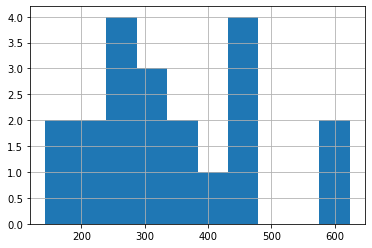

In [317]:
print('Average Living area for Afton Oakes is :',SubGrouped.LivingSqft.get_group('Afton Oaks').mean())
print('Median Living area for Afton Oakes is :',SubGrouped.LivingSqft.get_group('Afton Oaks').median())
SubGrouped.LivingSqft.get_group('Afton Oaks').hist()

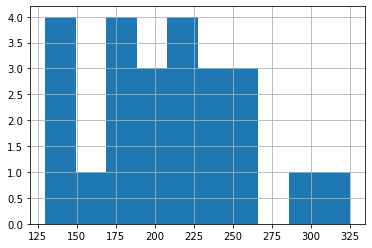

In [318]:
SubGrouped.DiningSqft.get_group('Afton Oaks').hist(bins=10)

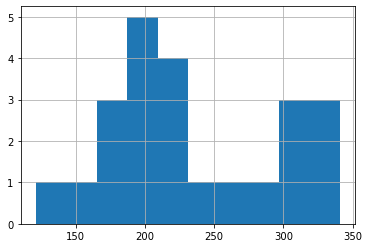

In [319]:
SubGrouped.KitchenSqft.get_group('Afton Oaks').hist(bins=10)


In [320]:
single_family_df['LivingSqft'] = single_family_df.groupby('SubName')['LivingSqft'].apply(lambda x: x.fillna(x.mean()))
single_family_df['DiningSqft'] = single_family_df.groupby('SubName')['DiningSqft'].apply(lambda x: x.fillna(x.mean()))
single_family_df['KitchenSqft'] = single_family_df.groupby('SubName')['KitchenSqft'].apply(lambda x: x.fillna(x.mean()))

In [321]:
single_family_df['LivingSqft'].isna().sum()

385

In [322]:
single_family_df['DiningSqft'].isna().sum()

472

In [323]:
single_family_df['KitchenSqft'].isna().sum()

287

We still have some null values and it seems there is no information for those subdivisions. lets drop them.

In [324]:
single_family_df=single_family_df[~single_family_df['DiningSqft'].isnull()]

In [325]:
single_family_df['LivingSqft'].isna().sum()

191

In [326]:
single_family_df['KitchenSqft'].isna().sum()

94

In [327]:
single_family_df=single_family_df[~single_family_df['LivingSqft'].isnull()]

In [328]:
single_family_df['KitchenSqft'].isna().sum()

67

In [329]:
single_family_df=single_family_df[~single_family_df['KitchenSqft'].isnull()]

## 1.9 Listing Price<a id='1.9_Listing_Price'></a>

In [330]:
single_family_df['Listing Price:'].isna().sum()

2

In [331]:
single_family_df=single_family_df[~single_family_df['Listing Price:'].isnull()]

In [332]:
single_family_df['Listing Price:']=single_family_df['Listing Price:'].str.split(' ').str[1]
single_family_df['Listing Price:']=single_family_df['Listing Price:'].str.replace(',','')
single_family_df['Listing Price:']=pd.to_numeric(single_family_df['Listing Price:'])
single_family_df.rename(columns = {'Listing Price:':'ListingPrice','Address:':'Address', 'Zip Code:':'ZipCode', 'County:':'County',
                                 'Subdivision:':'sub', 'Legal Description:':'Legal'},inplace=True)

In [333]:
single_family_df['ListingPrice'].describe()

count    7.614000e+03
mean     5.327173e+05
std      6.410879e+05
min      1.000000e+00
25%      2.413075e+05
50%      3.450000e+05
75%      5.600000e+05
max      1.450000e+07
Name: ListingPrice, dtype: float64

it seems minimum listing price is $1 which needs to be investigated.

In [334]:
single_family_df.loc[single_family_df.ListingPrice <10000]

,image_link,ListingPrice,Address,City:,ZipCode,County,Legal,Bedrooms:,Baths:,Stories:,...,DiningSqft,KitchenSqft,SubName,MedianApp,MedianYearBlt,MedianSqft,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate
4981,"['https://photos.harstatic.com/189947720/hr/img-1.jpeg?ts=2020-10-04T18:50:24.170', 'https://pho...",1,7626 Candlegreen Lane,Houston,77071,Harris County,W 60 FT OF LT 23 BLK 4 FONDREN SW SOUTHMEADOW SEC 2,3 Bedroom(s),2 Full Bath(s),1,...,168.0,201.285714,Fondren Sw Southmeadow,143407,1977,6900,147500.0,80.02,3566.0,2.5216


There is one house with the price less than $10000.

In [335]:
#removing the row with the price less than $10000
single_family_df = single_family_df[single_family_df.ListingPrice >= 10000]
single_family_df.ListingPrice.describe()

count    7.613000e+03
mean     5.327872e+05
std      6.411009e+05
min      2.390000e+04
25%      2.418100e+05
50%      3.450000e+05
75%      5.600000e+05
max      1.450000e+07
Name: ListingPrice, dtype: float64

## 1.10 Bedrooms<a id='1.10_Bedrooms'></a>

In [336]:
single_family_df[['Bedrooms:','Bedroom:','Primary Bedroom:']]

,Bedrooms:,Bedroom:,Primary Bedroom:
10,3 Bedroom(s),"[""12' X 10', 3rd"", '12\'10\' X 11\'4"", 1st', ""12' , 10', 3rd"", '12\'10\' , 11\'4"", 1st']","['16\'4"" X 12\'8"", 3rd', '16\'4"" , 12\'8"", 3rd']"
22,3 Bedroom(s),"['12X11, 3rd', '12X11, 1st', '3.66 x 3.35(m)', '3.66 x 3.35(m)']","['15X14, 3rd', '4.57 x 4.27(m)']"
23,3 Bedroom(s),"['12X11, 1st', '12X11, 3rd', '3.66 x 3.35(m)', '3.66 x 3.35(m)']","['15X14, 3rd', '4.57 x 4.27(m)']"
29,3 Bedroom(s),"['13 x 11, 1st', '11 x 10, 3rd', '13 , 11, 1st', '11 , 10, 3rd']","['17 x 13, 3rd', '17 , 13, 3rd']"
30,3 Bedroom(s),"['11x10, 3rd', '15x11, 1st', '3.35 x 3.05(m)', '4.57 x 3.35(m)']","['19X13, 3rd', '5.79 x 3.96(m)']"
...,...,...,...
11135,3 Bedroom(s),"['10x11, 1st', '10x11, 1st', '10x11, 1st', '3.05 x 3.35(m)', '3.05 x 3.35(m)', '3.05 x 3.35(m)']",NaN
11137,3 Bedroom(s),"['10x8, 1st', '10x8, 1st', '3.05 x 2.44(m)', '3.05 x 2.44(m)']","['12x14, 1st', '3.66 x 4.27(m)']"
11138,3 Bedroom(s),"['12x11, 1st', '12x11, 1st', '3.66 x 3.35(m)', '3.66 x 3.35(m)']","['13x15, 1st', '3.96 x 4.57(m)']"
11139,3 Bedroom(s),"['12x12, 1st', '12x12, 1st', '3.66 x 3.66(m)', '3.66 x 3.66(m)']","['13x15, 1st', '3.96 x 4.57(m)']"


In [337]:
single_family_df[['Bedrooms:','Bedroom:','Primary Bedroom:','Average Bedrooms:']].isna().sum()

Bedrooms:             15
Bedroom:              56
Primary Bedroom:     446
Average Bedrooms:     27
dtype: int64

First I calculate area for Bedroom and Primary Bedroom separately then fill null values with the average of area per subdivision and then add them as total bedrooms in Sqft. 

In [338]:
single_family_df['Primary_Bedroom_clean'] = single_family_df['Primary Bedroom:'].str.split(',')
single_family_df['Primary_Bedroom_clean'] = single_family_df['Primary_Bedroom_clean'].apply(area_calc)
single_family_df.update(single_family_df[['Primary_Bedroom_clean']].fillna(0))

single_family_df['Bedroom_clean'] = single_family_df['Bedroom:'].str.split(',')
single_family_df['Bedroom_clean'] = single_family_df['Bedroom_clean'].apply(area_calc)
single_family_df['Bedroom_clean'] = single_family_df.groupby('SubName')['Bedroom_clean'].transform(lambda x: x.fillna(x.mean()))

In [339]:
single_family_df['TotalBedSqft'] = single_family_df['Bedroom_clean'] + single_family_df['Primary_Bedroom_clean']

In [340]:
pd.options.display.max_colwidth = 100
single_family_df[['Bedrooms:','Bedroom:','Primary Bedroom:','Primary_Bedroom_clean','Bedroom_clean','TotalBedSqft']].sample(20,random_state=100)

,Bedrooms:,Bedroom:,Primary Bedroom:,Primary_Bedroom_clean,Bedroom_clean,TotalBedSqft
5979,3 Bedroom(s),"['17x14, 2nd', '14x11, 2nd', '5.18 x 4.27(m)', '4.27 x 3.35(m)']","['19X14, 2nd', '5.79 x 4.27(m)']",266.0,392.0,658.0
2927,4 Bedroom(s),"['12x12, 2nd', '13x13, 2nd', '12x12, 2nd', '3.66 x 3.66(m)', '3.96 x 3.96(m)', '3.66 x 3.66(m)']","['13x16, 2nd', '3.96 x 4.88(m)']",208.0,457.0,665.0
7678,3 - 4 Bedroom(s),"['13 x 11, 1st', '13x11, 1st', '13 , 11, 1st', '3.96 x 3.35(m)']","['20x16, 1st', '6.10 x 4.88(m)']",320.0,286.0,606.0
9498,5 Bedroom(s),"['13 x 11, 2nd', '12 x 11, 1st', '13 x 11, 1st', '13 x 13, 2nd', '13 , 11, 2nd', '12 , 11, 1st',...","['20x 15, 1st', '6.10 x 4.57(m)']",300.0,587.0,887.0
9267,5 Bedroom(s),"['16 x 19, 2nd', '12 x 18, 2nd', '12 x 15, 2nd', '12 x 14, 2nd', '16 , 19, 2nd', '12 , 18, 2nd',...","['15 x 22, 1st', '15 , 22, 1st']",330.0,868.0,1198.0
483,6 Bedroom(s),"['13x12, 2nd', '15x15, 3rd', '12x12, 2nd', '12x10, 2nd', '3.96 x 3.66(m)', '4.57 x 4.57(m)', '3....","['22x16, 2nd', '6.71 x 4.88(m)']",352.0,645.0,997.0
6117,4 Bedroom(s),"['14x14, 2nd', '14x12, 2nd', '13x13, 2nd', '4.27 x 4.27(m)', '4.27 x 3.66(m)', '3.96 x 3.96(m)']","['20x13, 1st', '6.10 x 3.96(m)']",260.0,533.0,793.0
8562,5 Bedroom(s),"['14x12, 2nd', '11x13, 1st', '11x15, 1st', '13x12, 2nd', '4.27 x 3.66(m)', '3.35 x 3.96(m)', '3....","['18x15, 1st', '5.49 x 4.57(m)']",270.0,632.0,902.0
8651,4 Bedroom(s),"['11X11, 2nd', '12X11, 1st', '12X11, 2nd', '3.35 x 3.35(m)', '3.66 x 3.35(m)', '3.66 x 3.35(m)']","['15X14, 1st', '4.57 x 4.27(m)']",210.0,385.0,595.0
5469,4 Bedroom(s),"['10x10, 1st', '9x9, 1st', '10x10, 1st', '3.05 x 3.05(m)', '2.74 x 2.74(m)', '3.05 x 3.05(m)']","['13x11, 1st', '3.96 x 3.35(m)']",143.0,281.0,424.0


In [341]:
single_family_df[single_family_df.TotalBedSqft==0][['Year Built:','Bedroom:','Primary Bedroom:','TotalBedSqft']]

,Year Built:,Bedroom:,Primary Bedroom:,TotalBedSqft
202,2015 / Appraisal District,"['na, 3rd', 'na, 1st', 'na, 3rd', 'na, 1st']","['na, 3rd', 'na, 3rd']",0.0
285,1940 / Appraisal District,"['0, 2nd', '0, 2nd', '0, 2nd', '0, 2nd']","['0, 2nd', '0, 2nd']",0.0
422,2020 / Builder,"['verify, 2nd', 'verify, 2nd', 'verify, 2nd', 'verify, 1st', 'verify, 2nd', 'verify, 2nd', 'veri...","['verify, 2nd', 'verify, 2nd']",0.0
783,1920 / Appraisal,"['1st', '1st', '1st', '1st']",NaN,0.0
786,1920 / Appraisal District,"['TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd']","['TBD, 2nd', 'TBD, 2nd']",0.0
...,...,...,...,...
10310,2020 / Builder,"['0x0, 1st', '0x0, 1st', '0x0, 2nd', '0,0, 1st', '0,0, 1st', '0,0, 2nd']","['0x0, 1st', '0,0, 1st']",0.0
10381,2020 / Builder,"['0x0, 1st', '0x0, 1st', '0x0, 1st', '0,0, 1st', '0,0, 1st', '0,0, 1st']","['0x0, 1st', '0,0, 1st']",0.0
10401,2013 / Appraisal District,"['n/A, 1st', 'n/a, 1st', 'n/A, 1st', 'n/a, 1st']","['n/a, 1st', 'n/a, 1st']",0.0
10607,1984 / Appraisal District,"['TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd']","['TBD, 1st', 'TBD, 1st']",0.0


In [342]:
single_family_df['TotalBedSqft'] = single_family_df.groupby('SubName')['TotalBedSqft'].transform(lambda x: x.fillna(x.mean()))

In [343]:
single_family_df[single_family_df.TotalBedSqft==0][['Year Built:','Bedroom:','Primary Bedroom:','TotalBedSqft']]

,Year Built:,Bedroom:,Primary Bedroom:,TotalBedSqft
202,2015 / Appraisal District,"['na, 3rd', 'na, 1st', 'na, 3rd', 'na, 1st']","['na, 3rd', 'na, 3rd']",0.0
285,1940 / Appraisal District,"['0, 2nd', '0, 2nd', '0, 2nd', '0, 2nd']","['0, 2nd', '0, 2nd']",0.0
422,2020 / Builder,"['verify, 2nd', 'verify, 2nd', 'verify, 2nd', 'verify, 1st', 'verify, 2nd', 'verify, 2nd', 'veri...","['verify, 2nd', 'verify, 2nd']",0.0
783,1920 / Appraisal,"['1st', '1st', '1st', '1st']",NaN,0.0
786,1920 / Appraisal District,"['TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd']","['TBD, 2nd', 'TBD, 2nd']",0.0
...,...,...,...,...
10310,2020 / Builder,"['0x0, 1st', '0x0, 1st', '0x0, 2nd', '0,0, 1st', '0,0, 1st', '0,0, 2nd']","['0x0, 1st', '0,0, 1st']",0.0
10381,2020 / Builder,"['0x0, 1st', '0x0, 1st', '0x0, 1st', '0,0, 1st', '0,0, 1st', '0,0, 1st']","['0x0, 1st', '0,0, 1st']",0.0
10401,2013 / Appraisal District,"['n/A, 1st', 'n/a, 1st', 'n/A, 1st', 'n/a, 1st']","['n/a, 1st', 'n/a, 1st']",0.0
10607,1984 / Appraisal District,"['TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd', 'TBD, 2nd']","['TBD, 1st', 'TBD, 1st']",0.0


In [344]:
single_family_df = single_family_df[single_family_df.TotalBedSqft!=0]

In [345]:
single_family_df[single_family_df.TotalBedSqft>1500][['Bedrooms:','Bedroom:','Primary Bedroom:','TotalBedSqft','Address','Building Sqft.:']]

,Bedrooms:,Bedroom:,Primary Bedroom:,TotalBedSqft,Address,Building Sqft.:
153,3 Bedroom(s),"['12x12, 1st', '14x132, 1st', '12x13, 1st', '3.66 x 3.66(m)', '4.27 x 40.23(m)', '3.66 x 3.96(m)']",NaN,2148.000000,3506 Chenevert Street,"1,338124(mÂ²) /Appraisal District"
196,4 Bedroom(s),"['12x11, 1st', '12x110, 2nd', '11x11, 1st', '11x11, 2nd', '3.66 x 3.35(m)', '3.66 x 33.53(m)', '...",NaN,1694.000000,1701 Ruth Street,"2,610242(mÂ²) /Appraisal District"
275,4 Bedroom(s),"['19x12, 2nd', '16x13, 2nd', '16x12, 2nd', '5.79 x 3.66(m)', '4.88 x 3.96(m)', '4.88 x 3.66(m)']","['37x25, 2nd', '11.28 x 7.62(m)']",1553.000000,3787 Purdue Street,"5,169480(mÂ²) /Appraisal District"
344,5 Bedroom(s),"['19x14, 2nd', '16x13, 2nd', '12x10, 2nd', '5.79 x 4.27(m)', '4.88 x 3.96(m)', '3.66 x 3.05(m)']","['18x18, 1st', '39x20, 2nd', '5.49 x 5.49(m)', '11.89 x 6.10(m)']",1698.000000,6339 Buffalo Speedway,"9,230857(mÂ²) /Appraisal District"
555,9 Bedroom(s),"['14x10, 1st', '10x12, 2nd', '12x14, 2nd', '18x8, 1st', '14x12, 1st', '12x12, 2nd', '17x15, 2nd'...","['15x15, 2nd', '14x13, 1st', '4.57 x 4.57(m)', '4.27 x 3.96(m)']",1546.000000,738 Yale Street,"8,681806(mÂ²) /Seller"
559,5 Bedroom(s),"['25x18, 1st', '22x30, 4th', '23x15, 2nd', '12x17, 3rd', '7.62 x 5.49(m)', '6.71 x 9.14(m)', '7....","['27x17, 1st', '8.23 x 5.18(m)']",2118.000000,832 Yale Street,"15,0001,394(mÂ²) /Appraisal District"
781,2 Bedroom(s),"['13 x 12, 1st', '13 , 12, 1st']","['13 1/2 x 15 1/2, 1st', '13 1/2 , 15 1/2, 1st']",19984.027778,515 W 14th Street,"1,135105(mÂ²) /Appraisal District"
816,5 Bedroom(s),"['17x14, 2nd', '27x24, 2nd', '17x14, 2nd', '14x13, 2nd', '5.18 x 4.27(m)', '8.23 x 7.32(m)', '5....","['19x19, 1st', '5.79 x 5.79(m)']",1667.000000,1035 Harvard Street,"6,814633(mÂ²) /Appraisal District"
1601,5 Bedroom(s),"['19x23, 2nd', '14x18, 2nd', '14x18, 2nd', '11x14, 2nd', '5.79 x 7.01(m)', '4.27 x 5.49(m)', '4....","['19x26, 2nd', '5.79 x 7.92(m)']",1589.000000,3257 Inwood,"9,426876(mÂ²) /Appraisal District"
1604,5 Bedroom(s),"['14x15, 2nd', '17x21, 2nd', '16x17, 2nd', '14x20, 2nd', '4.27 x 4.57(m)', '5.18 x 6.40(m)', '4....","['17x28, 2nd', '5.18 x 8.53(m)']",1595.000000,3315 Del Monte Drive,"7,223671(mÂ²) /Appraisal District"


In [346]:
single_family_df.loc[153,'TotalBedSqft'] = 484.8
single_family_df.loc[196,'TotalBedSqft'] = 506
single_family_df.loc[781,'TotalBedSqft'] = 365.25
single_family_df.loc[3687,'TotalBedSqft'] = 395.6
single_family_df.loc[4384,'TotalBedSqft'] = 550
single_family_df.loc[4390,'TotalBedSqft'] = 676
single_family_df.loc[4446,'TotalBedSqft'] = 1747
single_family_df.loc[5083,'TotalBedSqft'] = 696
single_family_df.loc[6437,'TotalBedSqft'] = 432
single_family_df.loc[6566,'TotalBedSqft'] = 1915
single_family_df.loc[6891,'TotalBedSqft'] = 653
single_family_df.loc[7505,'TotalBedSqft'] = 675.521
single_family_df.loc[7733,'TotalBedSqft'] = 820
single_family_df.loc[10176,'TotalBedSqft'] = 674
single_family_df.loc[10218,'TotalBedSqft'] = 655
single_family_df.loc[10849,'TotalBedSqft'] = 496

In [347]:
single_family_df['Bedrooms:'].isnull().sum()

15

There is 15 houses with no information about bedrooms and I will drop those rows.

In [348]:
single_family_df=single_family_df[~single_family_df['Bedrooms:'].isnull()]

In [349]:
single_family_df['Bedrooms:']=single_family_df['Bedrooms:'].str.split(' ').str[0]
single_family_df['Bedrooms:']=single_family_df['Bedrooms:'].astype(int)
single_family_df.rename(columns = {'Bedrooms:':'NoBed'},inplace=True)
single_family_df['NoBed'].describe()

count    7495.000000
mean        3.731288
std         0.790153
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max        10.000000
Name: NoBed, dtype: float64

In [350]:
single_family_df['Average Bedrooms:'].isna().sum()

27

In [351]:
single_family_df.groupby('SubName')['Average Bedrooms:'].value_counts()

SubName                           Average Bedrooms:
ASHFORD MANOR                     3.52                  5
Aberdeen Green                    3.46                  7
Aberdeen Trails                   3.84                  4
Afton Oaks                        3.56                 24
Airport Blvd Estates              3.47                  1
                                                       ..
Wrights Landing At Legends Trace  3.64                  5
Wyndham Village                   4.16                  2
YAUPON TRLS                       3.67                  1
Yorkshire                         4.59                  4
Young Mens                        2.85                  4
Name: Average Bedrooms:, Length: 1041, dtype: int64

In [352]:
single_family_df['Average Bedrooms:'].loc[single_family_df.SubName=='Afton Oaks']

2338    3.56
2339    3.56
2345    3.56
2351    3.56
2352    3.56
2353    3.56
2354    3.56
2355    3.56
2356    3.56
2359    3.56
2363    3.56
2376    3.56
2378    3.56
2383    3.56
2384    3.56
2391    3.56
2394    3.56
2403    3.56
2408    3.56
2412    3.56
2417    3.56
2418    3.56
2421    3.56
2426    3.56
Name: Average Bedrooms:, dtype: float64

It seems average bedroom is same for each subdivision. We can fill null values with the mean. 

In [353]:
single_family_df['Average Bedrooms:'] = single_family_df.groupby('SubName')['Average Bedrooms:'].transform(lambda x: x.fillna(x.mean()))

In [354]:
single_family_df['Average Bedrooms:'].isna().sum()

27

So there is no information for those subdivisions. lets drop these rows

In [355]:
single_family_df=single_family_df[~single_family_df['Average Bedrooms:'].isnull()]
single_family_df.rename(columns ={'Average Bedrooms:':'AvgBed'},inplace=True)

In [356]:
single_family_df.drop(['Bedroom:','Primary Bedroom:','Primary_Bedroom_clean','Bedroom_clean'],axis=1,inplace=True)

## 1.11 Bathrooms<a id='1.11_Bathrooms'></a>

In [357]:
single_family_df['Baths:'].isnull().sum()

3

In [358]:
single_family_df=single_family_df[~single_family_df['Baths:'].isnull()]

In [359]:
single_family_df[['Baths:']]

,Baths:
10,3 Full & 1 Half Bath(s)
22,3 Full & 1 Half Bath(s)
23,3 Full & 1 Half Bath(s)
29,3 Full & 1 Half Bath(s)
30,3 Full & 1 Half Bath(s)
...,...
11135,1 Full Bath(s)
11137,1 Full & 1 Half Bath(s)
11138,1 Full & 1 Half Bath(s)
11139,2 Full Bath(s)


In [360]:
single_family_df['FullBath']=single_family_df['Baths:'].str.split(' ').str[0].astype(int)

In [361]:
single_family_df['FullBath']

10       3
22       3
23       3
29       3
30       3
        ..
11135    1
11137    1
11138    1
11139    2
11140    1
Name: FullBath, Length: 7465, dtype: int32

In [362]:
No_Bath = single_family_df['Baths:'].str.split('&').str[1].str.strip()
No_Bath.fillna('0',inplace=True) 
single_family_df['HalfBath']=[int(item[0]) for item in No_Bath.str.split(' ')]
single_family_df['HalfBath'].replace(',','',inplace=True)
single_family_df[['FullBath','HalfBath']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7465 entries, 10 to 11140
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   FullBath  7465 non-null   int32
 1   HalfBath  7465 non-null   int64
dtypes: int32(1), int64(1)
memory usage: 145.8 KB


In [363]:
single_family_df.drop('Baths:',axis=1,inplace=True)

## 1.12 Stories<a id='1.12_Stories'></a>

In [364]:
single_family_df['Stories:'].value_counts()

2       3743
1       3126
3        364
1.5      165
4         52
2.5       12
5          1
2576       1
Name: Stories:, dtype: int64

There is one house with 2576 stories which I believe it is a typo. Lets take look at this home.

In [365]:
single_family_df['Stories:'].isnull().sum()

1

In [366]:
single_family_df=single_family_df[~single_family_df['Stories:'].isnull()]

In [367]:
single_family_df.rename(columns ={'Stories:':'Stories'},inplace=True)
single_family_df['Stories']=pd.to_numeric(single_family_df['Stories'])

In [368]:
single_family_df['Address'].loc[single_family_df['Stories']>4]

535        5334 Calle Cadiz Place
10448    22614 Auburn Valley Lane
Name: Address, dtype: object

The first one is an apartment and second one is 2 stories house. know we replace 2576 with 2.

In [369]:
single_family_df['Stories'].loc[single_family_df['Stories']==2576]=2

In [370]:
single_family_df['Stories'].value_counts()

2.0    3744
1.0    3126
3.0     364
1.5     165
4.0      52
2.5      12
5.0       1
Name: Stories, dtype: int64

Since we are looking for single family homes, those apartment are different from what we are looking for. so, images for those houses would be different. I will keep the houses with have equal or less than 3 stories.

In [371]:
single_family_df = single_family_df[single_family_df.Stories < 4]
single_family_df['Stories'].value_counts()

2.0    3744
1.0    3126
3.0     364
1.5     165
2.5      12
Name: Stories, dtype: int64

## 1.13 Style<a id='1.13_Style'></a>

In [372]:
single_family_df['Style:'].value_counts()

Traditional                          5269
Contemporary/Modern                   632
Ranch                                 324
Contemporary/Modern,Traditional       181
Other Style                           155
                                     ... 
Other Style,Split Level                 1
Ranch,Spanish                           1
Split Level,Victorian                   1
Other Style,Traditional,Victorian       1
Contemporary/Modern,Victorian           1
Name: Style:, Length: 80, dtype: int64

In [373]:
single_family_df['Style:'].isnull().sum()

0

In [374]:
single_family_df.rename(columns ={'Style:':'Style'},inplace=True)

In [375]:
single_family_df['Style'].unique()

array(['Contemporary/Modern', 'Contemporary/Modern,Traditional',
       'Traditional', 'Split Level', 'Other Style', 'Ranch',
       'Mediterranean,Traditional', 'Colonial', 'French',
       'Contemporary/Modern,Ranch,Traditional', 'Georgian,Traditional',
       'Colonial,Traditional', 'Mediterranean',
       'Colonial,Georgian,Traditional', 'Other Style,Traditional',
       'Contemporary/Modern,French', 'Contemporary/Modern,English,French',
       'French,Traditional', 'Spanish,Traditional', 'Georgian',
       'Colonial,Georgian', 'English,French,Traditional', 'Spanish',
       'Victorian', 'Traditional,Victorian',
       'Contemporary/Modern,English,French,Traditional',
       'Contemporary/Modern,French,Traditional', 'Other Style,Ranch',
       'Colonial,Contemporary/Modern',
       'Contemporary/Modern,Split Level,Traditional',
       'Contemporary/Modern,Mediterranean', 'Georgian,Victorian',
       'Colonial,French', 'Contemporary/Modern,Victorian',
       'Contemporary/Modern,Med

## 1.14 Year Built<a id='1.14_Year_Built'></a>

In [376]:
single_family_df['Year Built:'].isnull().sum()

22

In [377]:
single_family_df['Year Built:'].value_counts()

2020   / Builder               940
2005   / Appraisal District    151
2006   / Appraisal District    146
2015   / Appraisal District    143
1955   / Appraisal District    136
                              ... 
1925   / Seller                  1
1996   / Seller                  1
2006   / Seller                  1
1942   / Appraisal               1
1959   / Seller                  1
Name: Year Built:, Length: 278, dtype: int64

In [378]:
single_family_df=single_family_df[~single_family_df['Year Built:'].isnull()]
single_family_df['Year Built:']=single_family_df['Year Built:'].apply(lambda x:str(x).split(' ')[0])
single_family_df['Year Built:']=pd.to_datetime(single_family_df['Year Built:'],format='%Y').dt.year
single_family_df['Year Built:'].value_counts()

2020    985
2015    181
2005    167
2006    167
2014    163
       ... 
1923      1
1908      1
1904      1
1900      1
1896      1
Name: Year Built:, Length: 111, dtype: int64

Those houses with year build of 2020 mostly under construction and there is no images from inside or even outside. I will drop those houses too.

In [379]:
single_family_df.rename(columns ={'Year Built:':'YearBuilt'},inplace=True)

In [380]:
single_family_df = single_family_df[single_family_df.YearBuilt < 2020]
single_family_df['YearBuilt'].value_counts()

2015    181
2005    167
2006    167
2014    163
1955    147
       ... 
1922      1
1908      1
1904      1
1900      1
1896      1
Name: YearBuilt, Length: 109, dtype: int64

## 1.15 Building Sqft<a id='1.15_Building_Sqft'></a>

In [381]:
single_family_df['Building Sqft.:']

30       1,920178(mÂ²)  /Appraisal District
33                  2,162201(mÂ²)  /Builder
46       2,671248(mÂ²)  /Appraisal District
50       1,688157(mÂ²)  /Appraisal District
52       1,688157(mÂ²)  /Appraisal District
                        ...                
11133    1,651153(mÂ²)  /Appraisal District
11137    1,316122(mÂ²)  /Appraisal District
11138    1,160108(mÂ²)  /Appraisal District
11139    1,135105(mÂ²)  /Appraisal District
11140       83978(mÂ²)  /Appraisal District
Name: Building Sqft.:, Length: 6363, dtype: object

In [382]:
single_family_df['Building Sqft.:'].isnull().sum()

7

In [398]:
single_family_df=single_family_df[~single_family_df['Building Sqft.:'].isnull()]
single_family_df['Building Sqft.:']=single_family_df['Building Sqft.:'].apply(lambda x:x.split(',')[0] + x.split(',')[1][0:3] if ',' in x else x[0:3])
single_family_df['Building Sqft.:']=single_family_df['Building Sqft.:'].str.replace(',','')
single_family_df['Building Sqft.:']=pd.to_numeric(single_family_df['Building Sqft.:'])
single_family_df.rename(columns ={'Building Sqft.:':'BuildSqft'},inplace=True)

In [399]:
single_family_df.BuildSqft.describe()

count     6356.000000
mean      2811.410164
std       1278.253332
min        400.000000
25%       1963.750000
50%       2562.500000
75%       3365.250000
max      21032.000000
Name: BuildSqft, dtype: float64

## 1.16 Lot Size<a id='1.16_Lot_Size'></a>

In [400]:
single_family_df['Lot Size:'].isnull().sum()

48

In [401]:
single_family_df=single_family_df[~single_family_df['Lot Size:'].isnull()]

In [402]:
single_family_df['Lot Size:']

30       1,556 Sqft.145(mÂ²)  /Appraisal District
33       1,435 Sqft.133(mÂ²)  /Appraisal District
46       2,006 Sqft.186(mÂ²)  /Appraisal District
50       2,220 Sqft.206(mÂ²)  /Appraisal District
52       2,110 Sqft.196(mÂ²)  /Appraisal District
                           ...                   
11133    7,100 Sqft.660(mÂ²)  /Appraisal District
11137    7,100 Sqft.660(mÂ²)  /Appraisal District
11138    7,100 Sqft.660(mÂ²)  /Appraisal District
11139    7,100 Sqft.660(mÂ²)  /Appraisal District
11140    7,100 Sqft.660(mÂ²)  /Appraisal District
Name: Lot Size:, Length: 6308, dtype: object

In [403]:
single_family_df['Lot Size:']=single_family_df['Lot Size:'].str.replace(',','')
single_family_df['Lot Size:']=single_family_df['Lot Size:'].apply(lambda x:float(x.split(' ')[0])*43560 if 'Acres' in 
                                                                  x else float(x.split(' ')[0]))

# single_family_df['Lot Size:']=pd.to_numeric(single_family_df['Lot Size:'])
single_family_df.rename(columns ={'Lot Size:':'LotSize'},inplace=True)

In [404]:
single_family_df.LotSize.describe()

count    6.308000e+03
mean     1.112420e+04
std      2.801998e+04
min      0.000000e+00
25%      6.550000e+03
50%      8.165000e+03
75%      9.967500e+03
max      1.306800e+06
Name: LotSize, dtype: float64

the minimum lot size is 0 which need to investigate.

In [405]:
single_family_df[single_family_df.LotSize <1000]

,image_link,ListingPrice,Address,City:,ZipCode,County,Legal,NoBed,Stories,Style,...,MedianApp,MedianYearBlt,MedianSqft,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath
4975,"['https://photos.harstatic.com/190806088/hr/img-1.jpeg?ts=2020-10-25T08:51:53.280', 'https://pho...",173550,7807 Vickijohn,Houston,77071,Harris County,TR 2 BLK 2 FONDREN SW NORTHFIELD SEC 1,3,1.0,Contemporary/Modern,...,214780,1977,8740,229000.0,84.39,2743.0,2.6237,528.0,2,0


There is one house with lot size less than 1000. lest drop it.

In [406]:
single_family_df = single_family_df[single_family_df.LotSize >= 1000]
single_family_df.LotSize.describe()

count    6.307000e+03
mean     1.112597e+04
std      2.802185e+04
min      1.104000e+03
25%      6.550000e+03
50%      8.165000e+03
75%      9.971000e+03
max      1.306800e+06
Name: LotSize, dtype: float64

## 1.17 Maintenance Fee<a id='1.17_Maintenance_Fee'></a>

In [407]:
single_family_df['Maintenance Fee:']

30       ['$ 2250 / Annually', 'Mandatory / $2250 / Annually']
33       ['$ 1195 / Annually', 'Mandatory / $1195 / Annually']
46       ['$ 2244 / Annually', 'Mandatory / $2244 / Annually']
50       ['$ 1400 / Annually', 'Mandatory / $1400 / Annually']
52       ['$ 1400 / Annually', 'Mandatory / $1400 / Annually']
                                 ...                          
11133                                                       No
11137                                                       No
11138                                                       No
11139                                                       No
11140                                                       No
Name: Maintenance Fee:, Length: 6307, dtype: object

In [408]:
single_family_df['Maintenance Fee:'].isnull().sum()

20

In [409]:
single_family_df['Maintenance Fee:'].value_counts()

No                                                       1487
['$ 650 / Annually', 'Mandatory / $650 / Annually']       124
['$ 450 / Annually', 'Mandatory / $450 / Annually']       114
['$ 350 / Annually', 'Mandatory / $350 / Annually']       112
['$ 600 / Annually', 'Mandatory / $600 / Annually']       102
                                                         ... 
['$ 605 / Quarterly', 'Mandatory / $605 / Quarterly']       1
['$ 3800 / Annually', 'Mandatory / $3800 / Annually']       1
['$ 302 / Annually', 'Mandatory / $302 / Annually']         1
['$ 156 / Annually', 'Mandatory / $156 / Annually']         1
['$ 1117 / Annually', 'Mandatory / $1117 / Annually']       1
Name: Maintenance Fee:, Length: 789, dtype: int64

In [410]:
single_family_df['Maintenance Fee:'].isin(['No','No / $0','Voluntary / Annually','Voluntary /0/ Annually']).sum()

1534

In [411]:
def MaintenanceFee(fee):
    """This function calculates the Maintenance fee for this column"""
    if type(fee) != float:
        fee = fee.split(',')[0].split('/')
        if fee[0].strip() in ['No','No / $0','Voluntary / Annually','Voluntary /0/ Annually','Voluntary','Mandatory']:
            fee = 0
        elif len(fee) > 1 and fee[1].replace('\'','').strip() in ['Annually']:
            fee = float(fee[0].replace('$','').replace('\'','').replace(' ','').replace('[',''))
        elif len(fee) > 1 and fee[1].replace('\'','').strip() in ['Quarterly']:   
            fee = float(fee[0].replace('$','').replace('\'','').replace(' ','').replace('[',''))*4
        elif len(fee) > 1 and fee[1].replace('\'','').strip() in ['Monthly']:   
            fee = float(fee[0].replace('$','').replace('\'','').replace(' ','').replace('[',''))*12 
        else:
            fee = float(fee[0].replace('$','').replace('\'','').replace(' ','').replace('[',''))
    else:
        fee = 0
    return fee

In [412]:
single_family_df['MaintenanceFee'] = single_family_df['Maintenance Fee:'].apply(MaintenanceFee)

In [413]:
single_family_df.drop('Maintenance Fee:',axis=1,inplace=True)

## 1.18 Fireplace<a id='1.18_Fireplace'></a>

In [414]:
single_family_df['Fireplace:'].value_counts()

1/Gaslog Fireplace                                                             1191
1                                                                               762
1/Gas Connections                                                               636
1/Wood Burning Fireplace                                                        446
1/Gas Connections, Gaslog Fireplace                                             353
                                                                               ... 
1/Gas Connections, Mock Fireplace, Wood Burning Fireplace                         1
1/Gas Connections, Gaslog Fireplace, Mock Fireplace                               1
/Gaslog Fireplace, Wood Burning Fireplace                                         1
5/Gas Connections, Wood Burning Fireplace                                         1
3/Gas Connections, Gaslog Fireplace, Mock Fireplace, Wood Burning Fireplace       1
Name: Fireplace:, Length: 82, dtype: int64

In [415]:
pd.Series([str(x)[0]  for x in single_family_df['Fireplace:'] if x is not None]).value_counts()

1    4084
n    1652
2     409
3      88
/      44
4      22
5       8
dtype: int64

In [416]:
single_family_df['Fireplace:']=single_family_df['Fireplace:'].apply(lambda x:int(str(x)[0]) if str(x)[0]
                                                                    in ['1','2','3','4','5','6','7'] else 0)

In [417]:
single_family_df['Fireplace:'].value_counts()

1    4084
0    1696
2     409
3      88
4      22
5       8
Name: Fireplace:, dtype: int64

## 1.19 HOA Mandatory<a id='1.19_HOA_Mandatory'></a>

In [418]:
single_family_df['HOA Mandatory:']

30       Yes
33       Yes
46       Yes
50       NaN
52       Yes
        ... 
11133     No
11137     No
11138     No
11139     No
11140     No
Name: HOA Mandatory:, Length: 6307, dtype: object

We can fill null values for HOA by 'NO'.

In [419]:
single_family_df['HOA Mandatory:'][single_family_df['HOA Mandatory:'].isnull()]='No'
single_family_df.rename(columns ={'HOA Mandatory:':'HOA'},inplace=True)

In [420]:
missing = missing_cal(single_family_df)
missing.loc[missing['%'] > 0].sort_values(by="%",ascending=False)

,count,%
Median Appraised Value / Square ft.:,6307,100.000000
Legal,1,0.015855


Median Appraised Value / Square ft.: has 100% missing value we can drop it and also drop rows with null value for legal.

In [421]:
single_family_df.drop('Median Appraised Value / Square ft.:',axis = 1, inplace=True)
single_family_df=single_family_df[~single_family_df['Legal'].isnull()]

lets take a look at dataset to see if we need to rename some columns:

In [422]:
single_family_df.columns

Index(['image_link', 'ListingPrice', 'Address', 'City:', 'ZipCode', 'County',
       'Legal', 'NoBed', 'Stories', 'Style', 'YearBuilt', 'BuildSqft',
       'LotSize', 'Fireplace:', 'Heating:', 'Cooling:', 'Ice Maker:',
       'Microwave:', 'Compactor:', 'Dishwasher:', 'Disposal:', 'Roof:',
       'Foundation:', 'Private Pool:', 'Exterior Type:', 'Lot Description:',
       'Controlled Access:', 'Water Sewer:', 'Unit Location:', 'Area Pool:',
       'Dwelling Type:', 'HOA', 'List Type:', 'Other Fees:', 'AvgBed',
       'Average Baths:', 'Carport Description:', 'UtilitySqft', 'StudySqft',
       'GameSqft', 'BreakfastSqft', 'Garage', 'LivingSqft', 'DiningSqft',
       'KitchenSqft', 'SubName', 'MedianApp', 'MedianYearBlt', 'MedianSqft',
       'AvgNeighborValRange', 'MedianPrice/Sqft', 'PaidTax', 'TaxRate',
       'TotalBedSqft', 'FullBath', 'HalfBath', 'MaintenanceFee'],
      dtype='object')

In [423]:
single_family_df.reset_index(inplace=True,drop=True)

In [424]:
single_family_df.rename(columns = {'City:':'City','Fireplace:':'Fireplace', 'Heating:':'Heating', 'Cooling:':'Cooling',
                                   'Ice Maker:':'IceMaker', 'Microwave:':'Microwave','Compactor:':'Compactor',
                                   'Dishwasher:':'Dishwasher','Disposal:':'Disposal','Roof:':'Roof',
                                   'Foundation:':'Foundation','Private Pool:':'PrivatePool',
                                   'Exterior Type:':'ExteriorType','Lot Description:':'LotDes',
                                   'Controlled Access:':'ControlAccess','Water Sewer:':'WaterSewer',
                                   'Unit Location:':'UnitLoc','Area Pool:':'AreaPool','Dwelling Type:':'DwellingType',
                                   'List Type:':'ListType','Other Fees:':'OtherFees','Average Baths:':'AvgBaths',
                                   'Carport Description:':'CarportDescription'},inplace=True)

In [425]:
single_family_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6306 entries, 0 to 6305
Data columns (total 57 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image_link           6306 non-null   object 
 1   ListingPrice         6306 non-null   int64  
 2   Address              6306 non-null   object 
 3   City                 6306 non-null   object 
 4   ZipCode              6306 non-null   int64  
 5   County               6306 non-null   object 
 6   Legal                6306 non-null   object 
 7   NoBed                6306 non-null   int32  
 8   Stories              6306 non-null   float64
 9   Style                6306 non-null   object 
 10  YearBuilt            6306 non-null   int64  
 11  BuildSqft            6306 non-null   int64  
 12  LotSize              6306 non-null   float64
 13  Fireplace            6306 non-null   int64  
 14  Heating              6306 non-null   object 
 15  Cooling              6306 non-null   o

## 1.20 Other Fees<a id='1.20_Other_Fees'></a>

In [426]:
single_family_df.OtherFees.value_counts()

No / 0        2843
Yes / 250     1284
Yes / 200      432
Yes / 300      254
Yes / 150      208
              ... 
Yes / 89         1
Yes / 95         1
Yes / 780        1
Yes / 322        1
Yes / 1300       1
Name: OtherFees, Length: 189, dtype: int64

We need to clean this column and to do so I will change No value with 0 and calculate total fees for the rest.

In [427]:
single_family_df.OtherFees = single_family_df.OtherFees.apply(lambda x: float(x.split('/')[1].strip()))

In [428]:
single_family_df.OtherFees

0       250.0
1        80.0
2       250.0
3       350.0
4       250.0
        ...  
6301      0.0
6302      0.0
6303      0.0
6304      0.0
6305      0.0
Name: OtherFees, Length: 6306, dtype: float64

In [429]:
single_family_df.head()

,image_link,ListingPrice,Address,City,ZipCode,County,Legal,NoBed,Stories,Style,...,MedianYearBlt,MedianSqft,AvgNeighborValRange,MedianPrice/Sqft,PaidTax,TaxRate,TotalBedSqft,FullBath,HalfBath,MaintenanceFee
0,"['https://photos.harstatic.com/189100987/hr/img-1.jpeg?ts=2020-09-04T12:19:37.237', 'https://pho...",408000,2614 Capitol Street,Houston,77003,Harris County,LT 7 BLK 1 CAPITOL OAKS SEC 1 2ND AMEND,3,3.0,"Contemporary/Modern,Traditional",...,2012,1563,443500.0,200.05,8899.0,2.5466,522.0,3,1,2250.0
1,"['https://photos.harstatic.com/189116198/hr/img-1.jpeg?ts=2020-10-21T19:55:31.780', 'https://pho...",402115,2708 EaDo Grove Lane,Houston,77003,Harris County,LT 19 BLK 1 EaDo Grove,3,3.0,Contemporary/Modern,...,2018,1485,217000.0,192.51,2169.0,2.6554,474.0,3,1,1195.0
2,"['https://photos.harstatic.com/188179029/hr/img-1.jpeg?ts=2020-08-03T08:56:34.177', 'https://pho...",419000,619 Live Oak Street,Houston,77003,Harris County,LT 7 BLK 1 CAPITOL OAKS SEC 3 RP NO 1,3,3.0,Traditional,...,2012,1563,443500.0,200.05,8899.0,2.5466,320.0,3,1,2244.0
3,"['https://photos.harstatic.com/190180506/hr/img-1.jpeg?ts=2020-10-15T11:16:28.257', 'https://pho...",320000,1725 Aden Drive,Houston,77003,Harris County,LT 66 BLK 1 MIDTOWN VILLAGE,2,2.0,Split Level,...,2005,1904,259000.0,181.62,7078.0,2.5466,302.0,2,1,1400.0
4,"['https://photos.harstatic.com/189461143/hr/img-1.jpeg?ts=2020-10-26T15:31:30.800', 'https://pho...",305000,1716 Aden Mist Drive,Houston,77003,Harris County,LT 117 BLK 1 MIDTOWN VILLAGE,2,2.0,Traditional,...,2005,1904,259000.0,181.62,7155.0,2.5466,340.0,2,0,1400.0


## 1.21 Roof<a id='1.21_Roof'></a>

In [430]:
single_family_df.Roof.unique()

array(['Composition', 'Aluminum', 'Other', 'Tile', 'Composition, Other',
       'Aluminum, Composition', 'Composition, Slate', 'Slate',
       'Composition, Tile', 'Wood Shingle', 'Built Up, Composition',
       'Aluminum, Other', 'Other, Tile', 'Aluminum, Composition, Other',
       'Other, Wood Shingle', 'Built Up', 'Aluminum, Other, Wood Shingle',
       'Aluminum, Slate', 'Composition, Wood Shingle'], dtype=object)

To reduce number of category in roof type column I create a list of standard roof type and will match each category to standard list, then replace it with higher score.

In [431]:
standard_roof=['Composition','Aluminum','Tile','Slate','Wood Shingle','Built Up','Other']
#For each correct roof  type . in standard roof list
for roof in standard_roof:
    
    # Find matches in gender
    matches = process.extract(roof, single_family_df.Roof,
                 limit = single_family_df.shape[0])
    
    
# For each possible_match with similarity score >= 90
    for possible_match in matches:
        if possible_match[1] >= 90:
      
            
            matching = single_family_df.Roof == possible_match[0]
           # I decided to use 'W' for female since there is high similarity between 'female' and 'male' 
        single_family_df.loc[matching , 'Roof'] = roof

In [432]:
single_family_df.Roof.unique()

array(['Composition', 'Aluminum', 'Other', 'Tile', 'Slate',
       'Wood Shingle', 'Built Up'], dtype=object)

## 1.21 Foundation<a id='1.21_Foundation'></a>

In [433]:
single_family_df.Foundation.unique()

array(['Slab', 'Block & Beam', 'Slab on Builders Pier', 'Pier & Beam',
       'Pier & Beam, Slab', 'Slab, Slab on Builders Pier', 'Other, Slab',
       'Pier & Beam, Slab on Builders Pier', 'Block & Beam, Slab',
       'Other, Pier & Beam', 'Other', 'Block & Beam, Pier & Beam',
       'Block & Beam, Slab on Builders Pier',
       'Other, Slab on Builders Pier', 'On Stilts'], dtype=object)

In [434]:
standard_foundation=['Slab','Block & Beam','Pier & Beam','On Stilts','Other']
for found in standard_foundation:
    
    # Find matches in gender
    matches = process.extract(found, single_family_df.Foundation,
                 limit = single_family_df.shape[0])
    
    
# For each possible_match with similarity score >= 90
    for possible_match in matches:
        if possible_match[1] >= 90:
      
            
            matching = single_family_df.Foundation == possible_match[0]
           # I decided to use 'W' for female since there is high similarity between 'female' and 'male' 
        single_family_df.loc[matching , 'Foundation'] = found
print(single_family_df.Foundation.unique())

['Slab' 'Block & Beam' 'Pier & Beam' 'Other' 'On Stilts']


In [435]:
single_family_df.ExteriorType.unique()

array(['Cement Board, Stucco', 'Cement Board', 'Brick, Wood',
       'Brick, Cement Board, Wood', 'Brick, Cement Board',
       'Brick & Wood, Cement Board', 'Stucco', 'Brick, Vinyl, Wood',
       'Brick, Other', 'Other', 'Brick', 'Brick & Wood', 'Wood',
       'Brick & Wood, Cement Board, Wood', 'Cement Board, Stone',
       'Brick, Stucco', 'Stone, Stucco', 'Asbestos, Wood',
       'Brick, Stone, Stucco, Vinyl, Wood', 'Brick Veneer, Stucco',
       'Cement Board, Stone, Wood', 'Aluminum, Vinyl', 'Stone',
       'Stucco, Wood', 'Other, Wood', 'Brick & Wood, Brick',
       'Asbestos, Brick & Wood', 'Brick, Vinyl', 'Brick Veneer',
       'Cement Board, Other, Stone, Wood', 'Brick, Stone, Stucco',
       'Brick Veneer, Stone', 'Other, Stucco', 'Stone & Wood, Stucco',
       'Unknown', 'Cement Board, Wood', 'Aluminum, Other',
       'Brick & Wood, Stone & Wood', 'Aluminum, Brick, Vinyl, Wood',
       'Cement Board, Stone, Stucco', 'Cement Board, Unknown',
       'Brick & Wood, Cement Boar

In [436]:
single_family_df.to_csv('../data/processed/SingleFamily.csv',index=False)